In [1]:
import matplotlib
matplotlib.use('PS')
%matplotlib inline

# SAIO vs GEQO comparison - report

## Introduction

This is an aggregated report on comparison of two alternative join order optimizers:

* GEQO - Genetic Query Optimizer (current default optimizer in Postgres)
* SAIO - Simulated Annealing based Join Order optimizer (PGXN extension for Postgres)

The tests compare query costs, optimizing time and memory used.

## Methodology
GEQO and SAIO are tested on many different schemas and queries. To ensure proper representation of each join order optimizer abilities, each query has been tested on a range of parameters:

* GEQO has been tested with GEQO effort in range 0 to 10
* SAIO has been tested with different combinations of: 
    * equilibrium factor (determines the number of equilibrium loops)
    * temperature reduction (temperature is multiplied by this fraction in each iteration until the system freezes)

Some parameters of SAIO were fixed to reduce testing time:

* initial temperature (affects initial randomness of the algorithm and the total number of iterations)
* steps before freeze

FROM_COLLAPSE_LIMIT and JOIN_COLLAPSE_LIMIT have been set to 200.


## Testing data
The testing data (DB schemas and queries) has been divided into following sections:

### Provided data
SQL scripts that were written by hand. Mostly for the previous iteration of SAIO.

### Programatically generated data
SQL scripts automatically generated by Python scripts

Schemas:

* 20-150 tables without constraints
* 20-150 tables with constraints


Flat queries:

* 15-20 JOINS (JOINS, LEFT JOINS, RIGHT JOINS, mixed)
* 20 JOINS (...)
* 30 JOINS
* 50 JOINS
* 70 JOINS
* 100 JOINS
* 130 JOINS

Nested queries:

* 15-20 JOINS (LEFT, RIGHT, mix)
* 20-25 JOINS
* 30-35 JOINS 
* 50-60 JOINS
* 70-80 JOINS


### Industrial examples
This would be awesome to include such examples. No examples yet.

The biggest query that I found during the search was on StackOverflow: http://stackoverflow.com/questions/15769643/postgresql-query-optimization-with-many-left-joins?rq=1, which had 13 joins.


#Test summary

#Conclusions

This report presents the behaviour of SAIO and GEQO for a number of queries. It doesn't show superiority of SAIO however it indicates that SAIO is worth further development and can possibly replace GEQO for more complicated queries.

There is number of cases where SAIO outperforms GEQO in terms of estimated total query cost. Unfortunately SAIO often produces worse results in terms of total cost, used memory and optimizing time.

##Cases where GEQO clearly wins:

In these cases GEQO constantly creates plans with lower cost, needs less time and memory.

* Queries with cartesian joins such as:
    
    ```sql
    SELECT * FROM tab_1, tab_2 ... tab_N 
        WHERE (tab_1.col_1 = tab_2.col_1) AND (..) AND (tab_1.col_1 = tab_N.col_1);
    ```  

* Queries with many JOINS and LEFT JOINS such as:
    
    ```sql
    SELECT * FROM tab_1 
        [LEFT]JOIN tab_2 on tab_1.col_1 = tab_2.col_2
        ...
        [LEFT]JOIN tab_N on tab_N.col_X = tab_Y.col_Z;
    ```

##Cases where SAIO wins

Here we can observe that SAIO constantly finds solutions with lower cost.

* Queries with many RIGHT JOINS such as:
    
    ```sql
    SELECT * FROM tab_1 
        RIGHT JOIN tab_2 on tab_1.col_1 = tab_2.col_2
        ...
        RIGHT JOIN tab_N on tab_N.col_X = tab_Y.col_Z;
    ```
* Nested queries:

    ```sql
        SELECT * FROM tab_1 
        [LEFT/RIGHT/] JOIN (
            SELECT * FROM tab_2
                [LEFT/RIGHT/] JOIN tab_3.col_A = tab_2.col_B
                ...
                [LEFT/RIGHT/] JOIN tab_W.col_X = tab_Y.col_Z
        ) AS subquery_1 ON TRUE     
        ...
        [LEFT/RIGHT/] JOIN (
        ) AS subquery_N ON TRUE;
    ```

This benchmark should be treated with a grain of salt as it doesn't cover all the possible cases (it can be improved with some suggestions). For a production system, join order optimizer should be chosen after checking it's performance on a few expected query types.

# Test details
In this section one can find more detailed information about the testing process - schemas and queries used. Also graphs that highlight performance of each of the algorithms.

In [2]:
import matplotlib.pyplot as plt # side-stepping mpl backend
from pylab import *
import numpy as np


def plot_geqo_against_average_saio(results_saio, results_geqo, title):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19,4))
    
    axes[0].plot(results_geqo[:,0], results_geqo[:,4], label="geqo cost")
    axes[0].plot(results_geqo[:,0],[np.average(results_saio[:,4])]*len(results_geqo[:,4]), label="average saio cost")
    axes[0].set_xlabel('geqo effort')
    axes[0].set_ylabel('cost')
    axes[0].set_title(title)
    axes[0].legend()
    
    axes[1].plot(results_geqo[:,0], results_geqo[:,5], label="geqo time")
    axes[1].plot(results_geqo[:,0],[np.average(results_saio[:,5])]*len(results_geqo[:,5]), label="average saio time")
    axes[1].set_xlabel('geqo effort')
    axes[1].set_ylabel('time [s]')
    axes[1].set_title(title)
    axes[1].legend()
    
    axes[2].plot(results_geqo[:,0], results_geqo[:,6]/1000, label="geqo memory")
    axes[2].plot(results_geqo[:,0],[np.average(results_saio[:,6])/1000]*len(results_geqo[:,6]), label="average saio memory")
    axes[2].set_xlabel('geqo effort')
    axes[2].set_ylabel('memory [MB]')
    axes[2].set_title(title)
    axes[2].legend()
    plt.show()
    

def plot_comparison(results_saio, results_geqo, title):   
    labels = ['GEQO', 'SAIO']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19,4))
    axes[0].boxplot((results_geqo[:,4], results_saio[:,4]), labels=labels, showmeans=True)
    axes[0].set_ylabel('Cost []')
    axes[0].grid(True)

    axes[1].boxplot((results_geqo[:,5], results_saio[:,5]), labels=labels, showmeans=True)
    axes[1].set_ylabel('Optimizing time [s]')
    axes[1].grid(True)

    axes[2].boxplot((results_geqo[:,6]/1000, results_saio[:,6]/1000), labels=labels, showmeans=True)
    axes[2].set_ylabel('Memory usage [MB]')
    axes[2].grid(True)
    
    fig.suptitle(title, fontsize='15')
    plt.show()
    
def plot_space(results_saio, results_geqo):
    geqo_avg_cost = np.average(results_geqo[:,4])
    geqo_avg_time = np.average(results_geqo[:,5])
    geqo_avg_memory = np.average(results_geqo[:,6])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    X, Y = results_saio[:,0], results_saio[:,2]
    cost, time, memory = results_saio[:,4], results_saio[:,5], results_saio[:,6]
    
    plt.subplot(1,3,1)
    #print len(cost)
    cost = cost.reshape(9, 11) / geqo_avg_cost
    im_cost = plt.imshow(cost, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_cost)
    plt.title('SAIO cost / avg(GEQO cost)')
    plt.grid(True)
    
    plt.subplot(1,3,2)
    time = time.reshape(9, 11) / geqo_avg_time
    im_time = plt.imshow(time, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_time)
    plt.title('SAIO time / avg(GEQO time) [s/s]')
    plt.grid(True)
   
    plt.subplot(1,3,3)
    memory = (memory.reshape(9, 11)/1000) / (geqo_avg_memory/1000)
    im_memory = plt.imshow(memory, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_memory)
    plt.title('SAIO memory / avg(GEQO memory) [MB/MB]')
    plt.grid(True)
    plt.show()
    

def plot_query_plan_tree_height_comparison(test_case_name):
    from benchmarks.helpers import query_plans as q
    saio_depths, saio_costs = q.get_depths_with_costs_from_test_case(
        test_case_name+'*saio*[0-9]', '/home/dev/projects/saio_benchmarks/benchmarks/current_output'
    )
    geqo_depths, geqo_costs = q.get_depths_with_costs_from_test_case(
        test_case_name+'*geqo*[0-9]', '/home/dev/projects/saio_benchmarks/benchmarks/current_output'
    )
    plt.figure()

    #plt.plot(sorted(saio_depths), label="SAIO plan tree_depth")
    #plt.plot(sorted(geqo_depths), label="GEQO plan tree depth")
    plt.scatter(saio_depths, saio_costs, label="SAIO", marker="o", s=100, c="green")
    plt.scatter(geqo_depths, geqo_costs, label = "GEQO", marker="s", s=100, c="blue")
    plt.title("Query trees depth and cost")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlabel('index number')
    #plt.ylabel('tree depth')
    plt.xlabel('query plan tree depth')
    plt.ylabel('total query cost')
    plt.show()

    
def display_info_for_test_case(test_case_name):
    #with open('benchmarks/'+test_case_name, 'r') as f:
    #    print f.read()
    
    saio_fname = "benchmarks/current_output/"+test_case_name + '.saio.out'
    geqo_fname = "benchmarks/current_output/"+test_case_name + '.geqo.out'
    
    #equilibrium_factor, initial_temperature, temperature_reduction_factor, steps_before_frozen, cost, time, memory
    results_saio = np.loadtxt(saio_fname)
    #geqo_effort, geqo_pool_size, geqo_generations, geqo_selection_bias, cost, time, memory
    results_geqo = np.loadtxt(geqo_fname)

    plot_comparison(results_saio, results_geqo, test_case_name)
    plot_geqo_against_average_saio(results_saio, results_geqo, 'GEQO vs SAIO ' + test_case_name)
    plot_space(results_saio, results_geqo)
    plot_query_plan_tree_height_comparison(test_case_name)
    
    import os
    os.chdir('/home/dev/projects/saio_benchmarks/')

## Provided queries
These queries were provided to test the previous iteration of SAIO back in 2010.

### MODERATELY COMPLEX QUERY

Here we can see that SAIO is is finding solutions comparable to GEQO. The optimizing time may be comparable to GEQO depending on the parameters of the algorithms. SAIO requires more memory than GEQO.

What's interesting - looking at 'query cost vs tree depth' plot, we can see that while SAIO explores a big number of different trees, GEQO is stuck near just one solution.

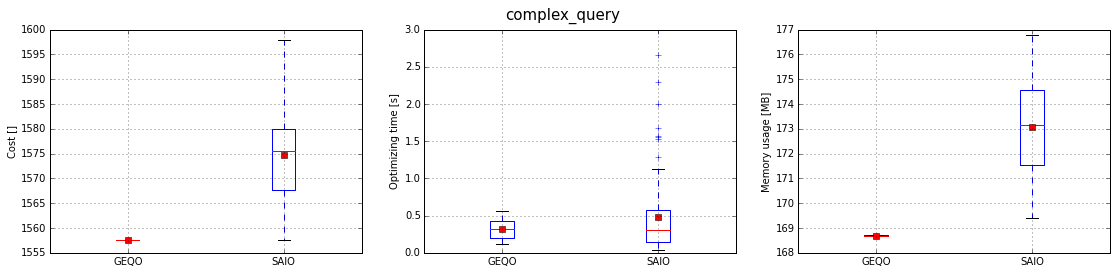

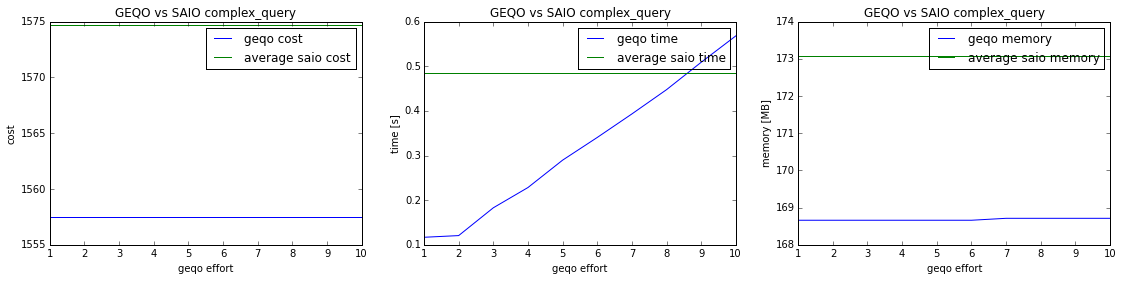

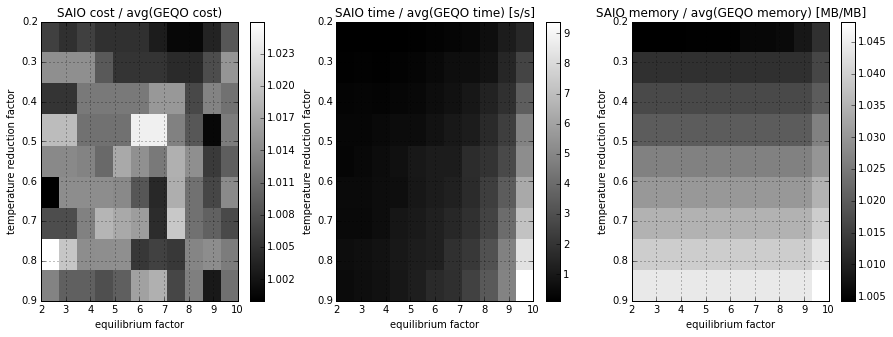

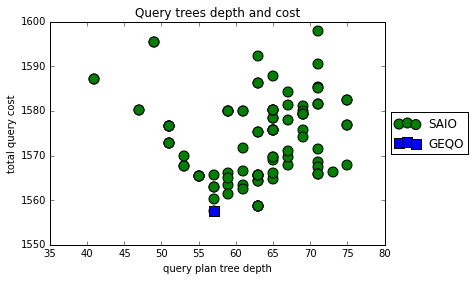

In [3]:
display_info_for_test_case('complex_query')

### COMPLEX QUERY

This query is based on a schema with multiple constraints.

![](static/schemasql.png)

There are 5 views created on this schema. These views contain over 360 JOINS of different kind. The final query selects data from these views joining them with tables from the schema using 13 JOINS.

Here SAIO clearly outperforms GEQO finding join order with lower cost in shorter time.

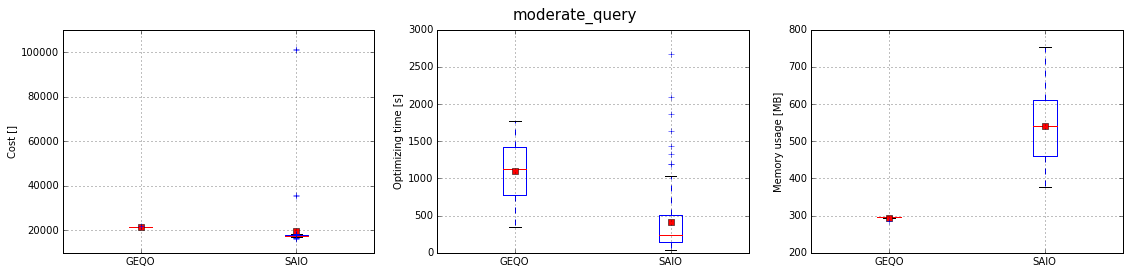

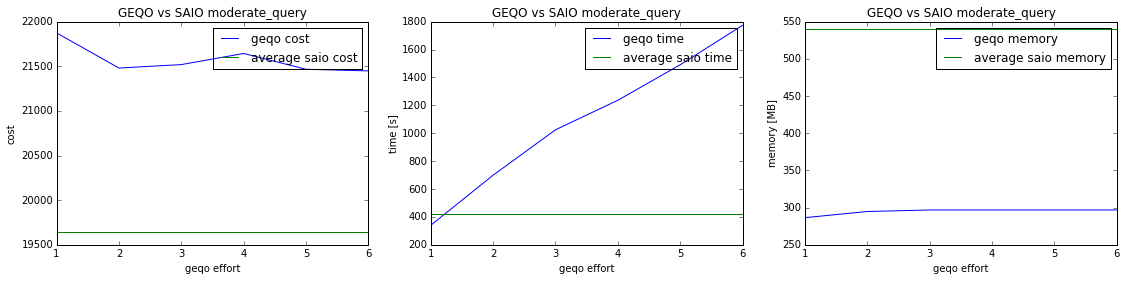

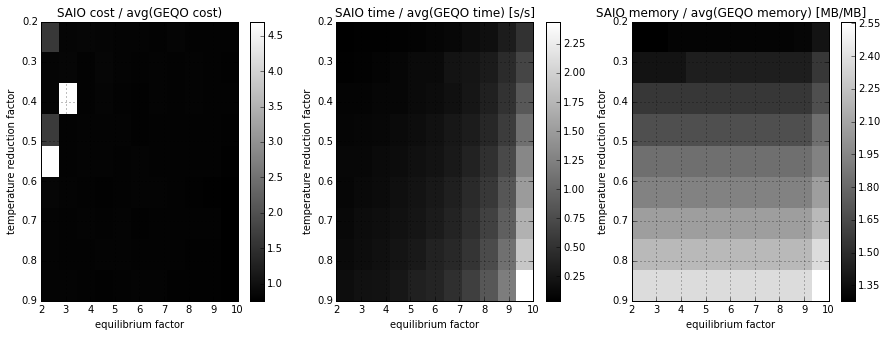

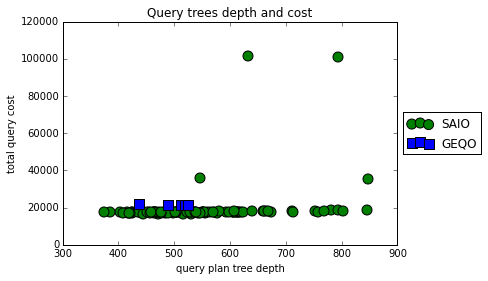

In [4]:
import sys
sys.setrecursionlimit(2000) # for finding depth of a very deep python dict
display_info_for_test_case('moderate_query')

## Programatically generated queries

### star query - cartesians

These queries look like this:

```sql
SELECT * FROM tab_1, tab_2 ... tab_N 
    WHERE (tab_1.col_1 = tab_2.col_1) AND (..) AND (tab_1.col_1 = tab_N.col_1);
```

####30 arms

The best solutions here were found by SAIO, however average solution found by GEQO was much better than average SAIO solution. SAIO also needed more time and more memory to optimize the table order for this query.

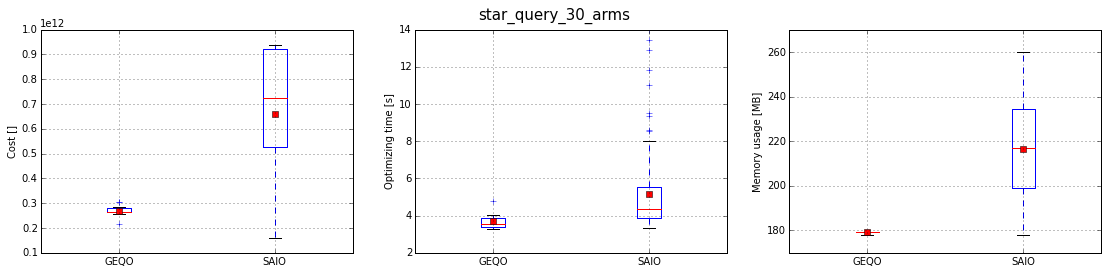

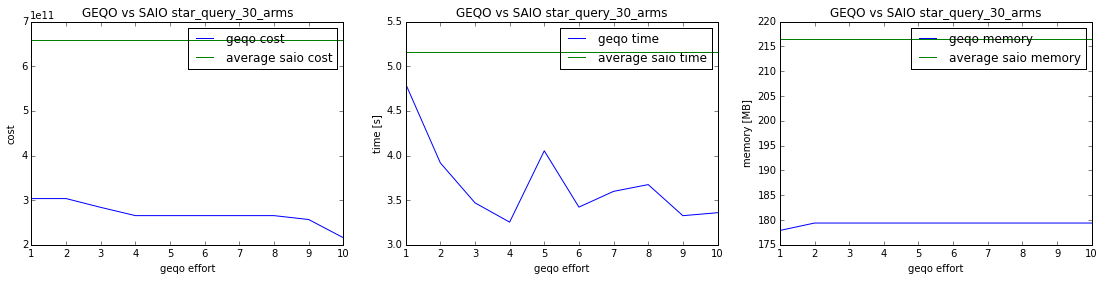

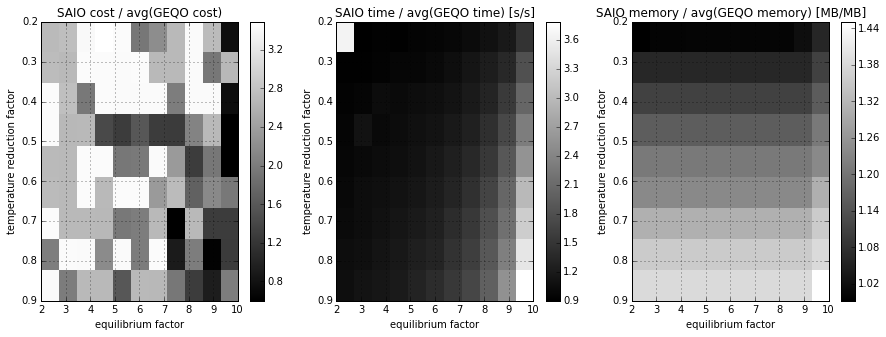

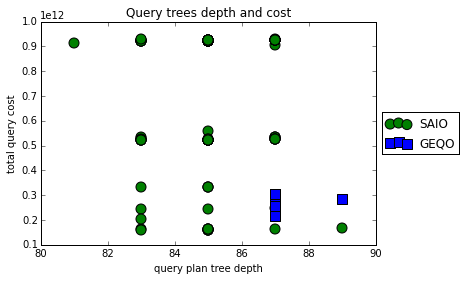

In [16]:
display_info_for_test_case('star_query_30_arms')

####50 arms

The same holds for this query.

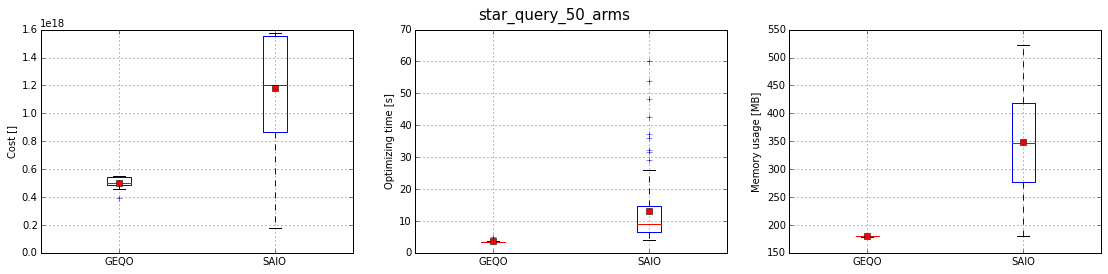

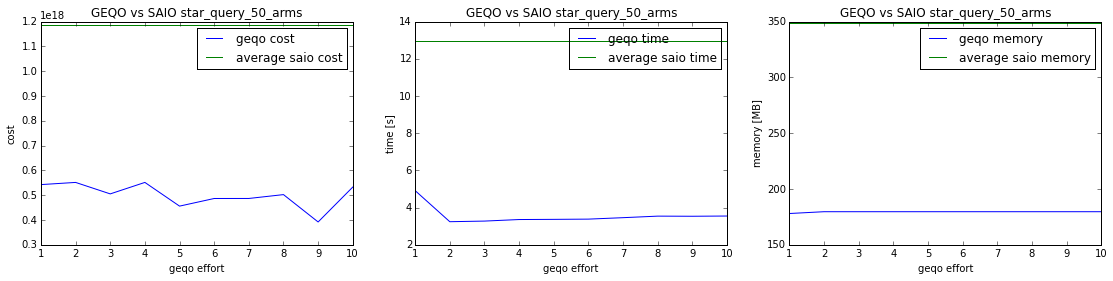

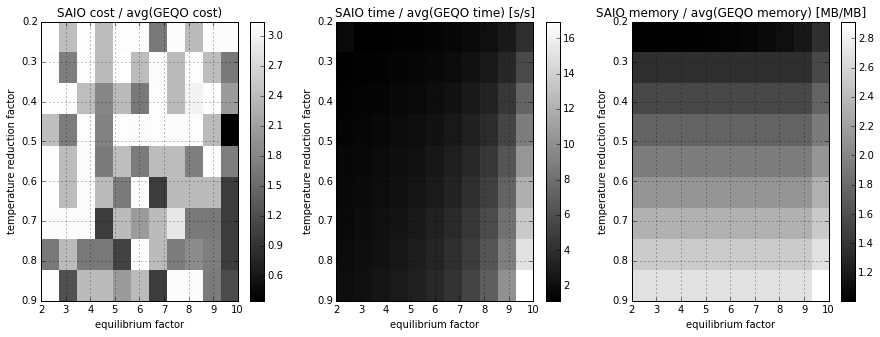

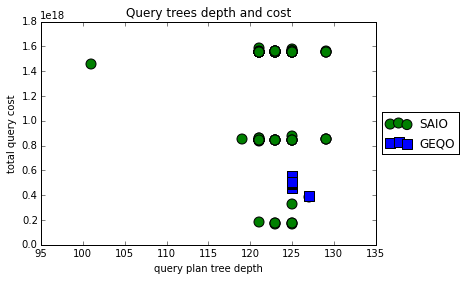

In [17]:
display_info_for_test_case('star_query_50_arms')

#### 80 arms

The result is the same as for the previous queries. GEQO finds better average solution than SAIO in shorter time using much less memory.

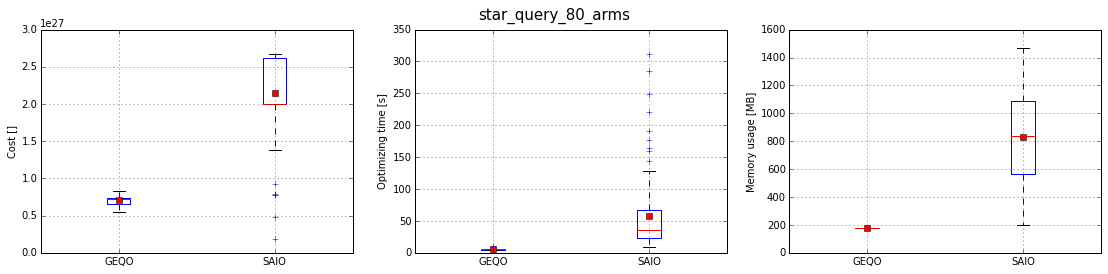

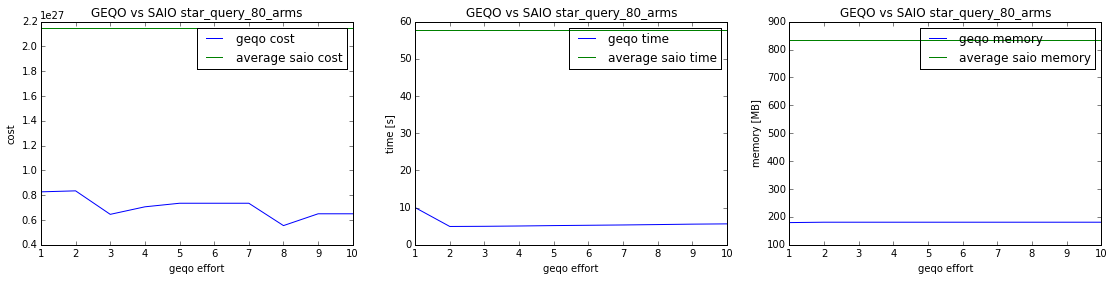

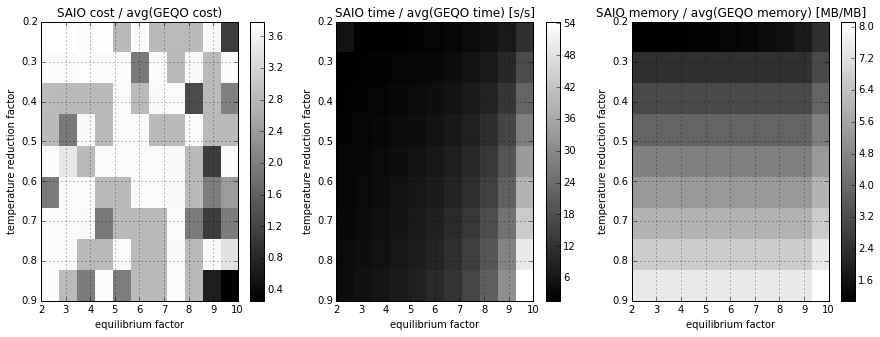

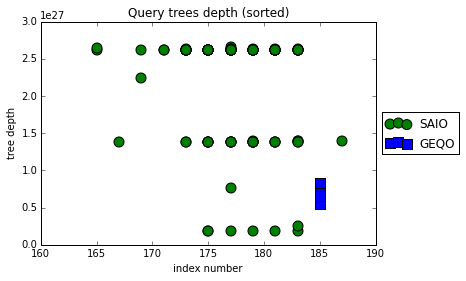

In [13]:
display_info_for_test_case('star_query_80_arms')

### star query - joins

These queries look like:

```sql
SELECT * FROM center JOIN arm0 ON (arm0.col = center.col0 or arm0.col = center.col0)
 JOIN arm1 ON (arm1.col = center.col1 or arm1.col = center.col2)
 ...
 JOIN armN ON (armN.col = center.colN or armM.col = center.colN);
```

####30 arms

Still the same conclusions as for previous cartesian queries. GEQO wins.

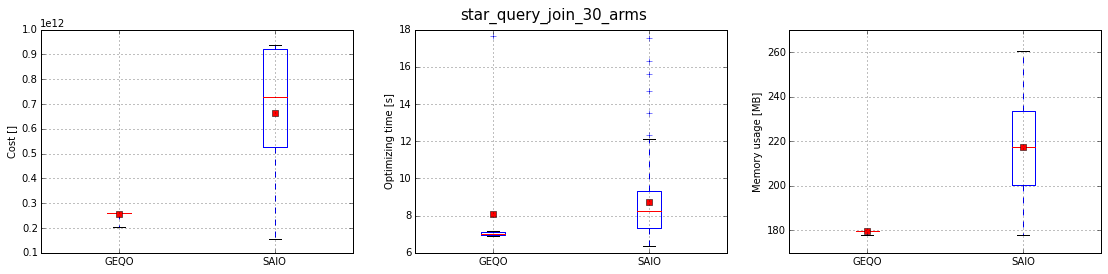

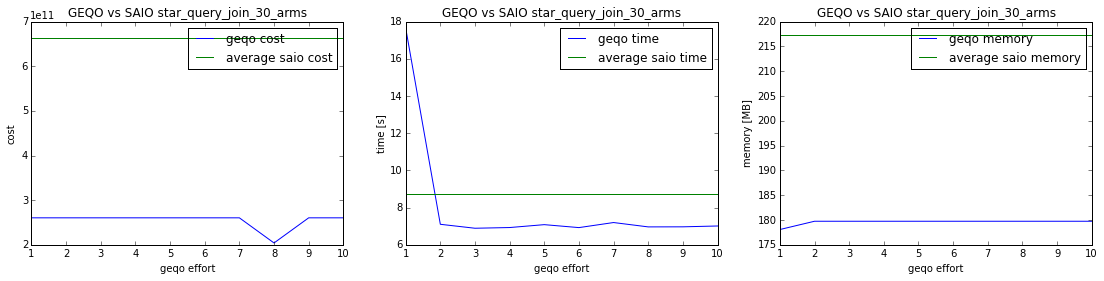

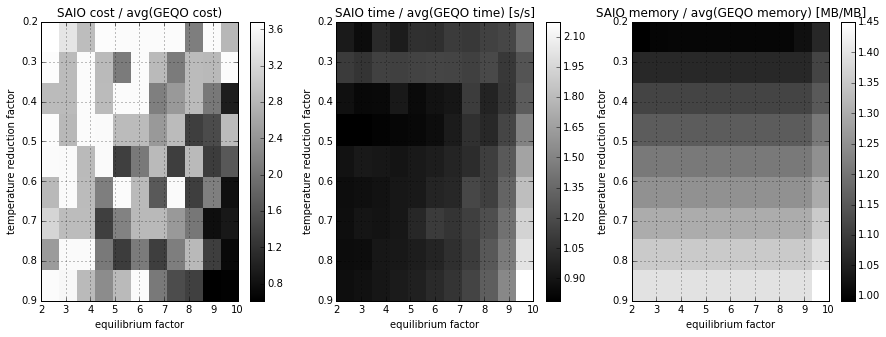

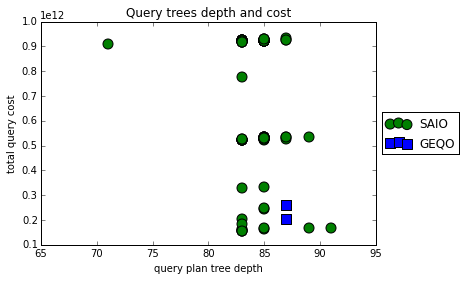

In [18]:
display_info_for_test_case('star_query_join_30_arms')

####50 arms

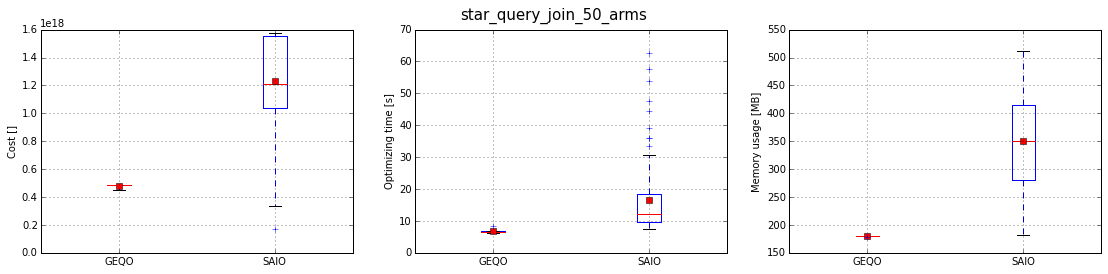

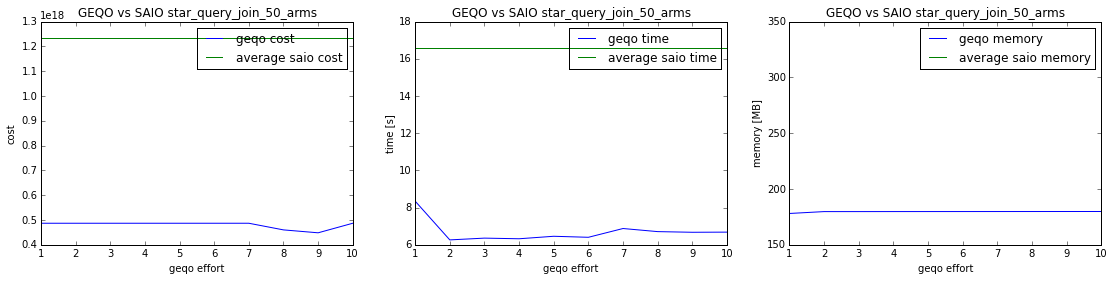

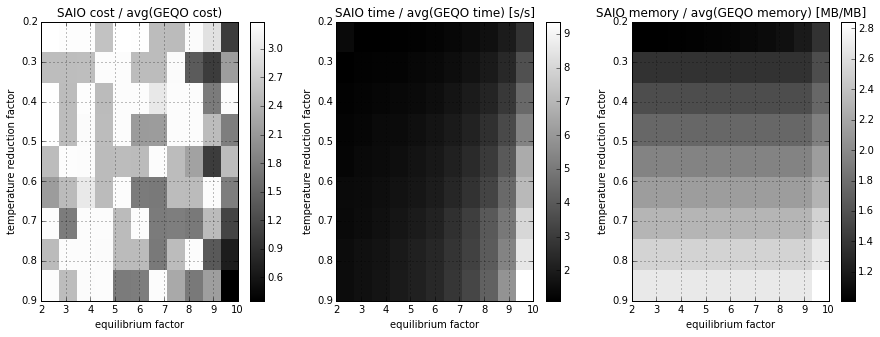

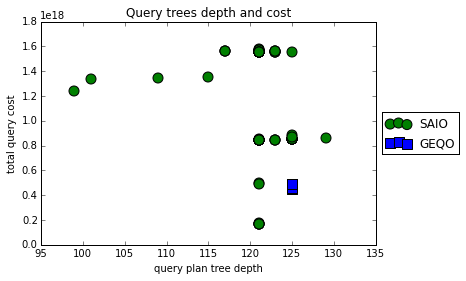

In [19]:
display_info_for_test_case('star_query_join_50_arms')

### flat queries

```sql
SELECT * FROM  table_0  
    JOIN/LEFT JOIN/RIGHT JOIN table_random ON table_random.col_random = table_random2.col_random2
    ...
    JOIN/LEFT JOIN/RIGHT JOIN table_random ON table_random.col_random = table_random2.col_random2;

```

####15 JOINS (JOINS, LEFT JOINS, RIGHT JOINS)

For queries with 15 JOINS we can see that the results generated by the libraries are pretty much comparable. GEQO has a bit worse average and median solution but it is more predictable than SAIO.

For queries with 15 LEFT JOINS SAIO finds worse solutions but needs less time and memory than GEQO.

For queries with 15 RIGHT JOINS we can see that GEQO returns some strangely high estimations. It looks like bushy trees produced by SAIO are more suitable to model queries with many RIGHT JOINs.

For a mixed query with 5 JOINS, 5 LEFT JOINS and 5 RIGHT JOINS SAIO wins again. This is probably due to presence of RIGHT JOINs in the query. GEQO doesn't seem to handle them well.

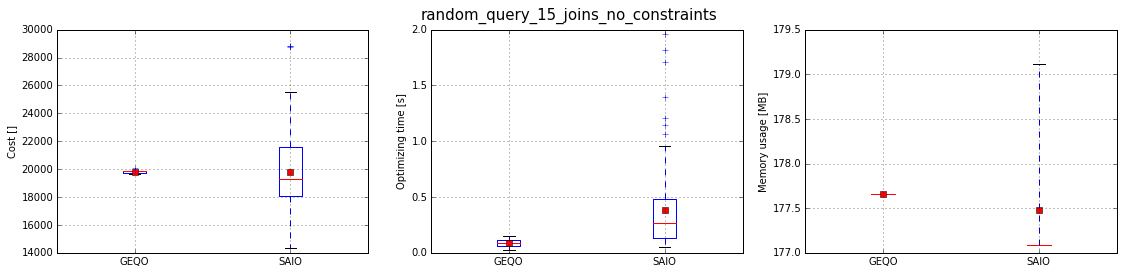

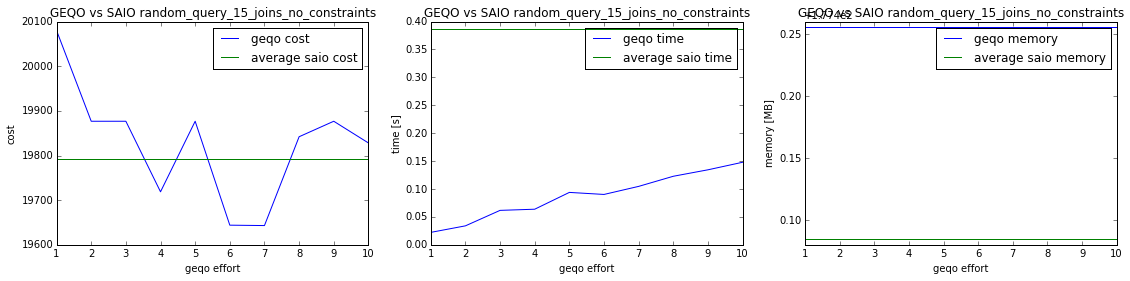

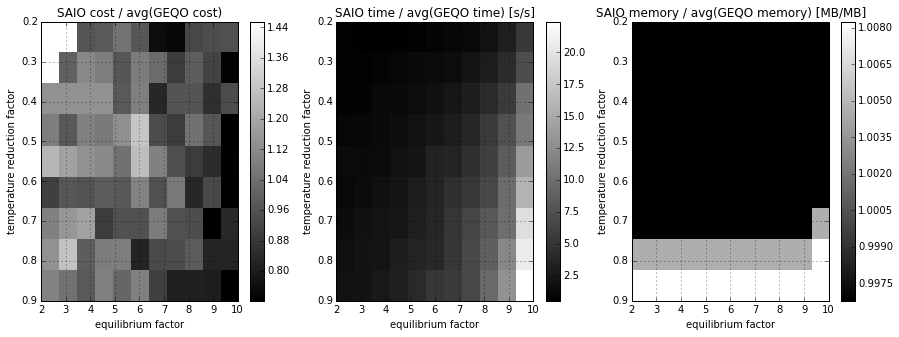

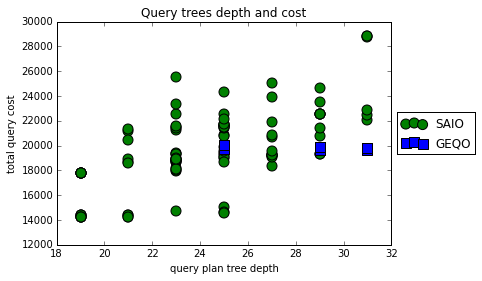

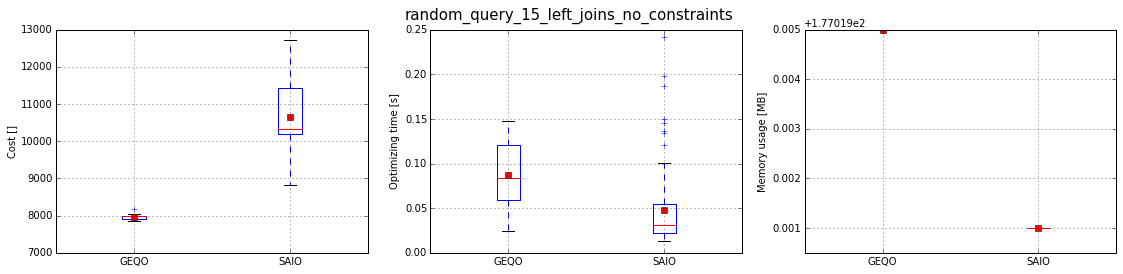

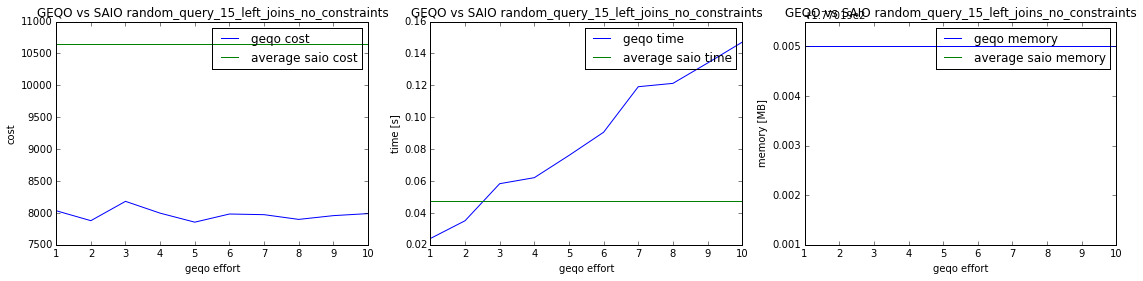

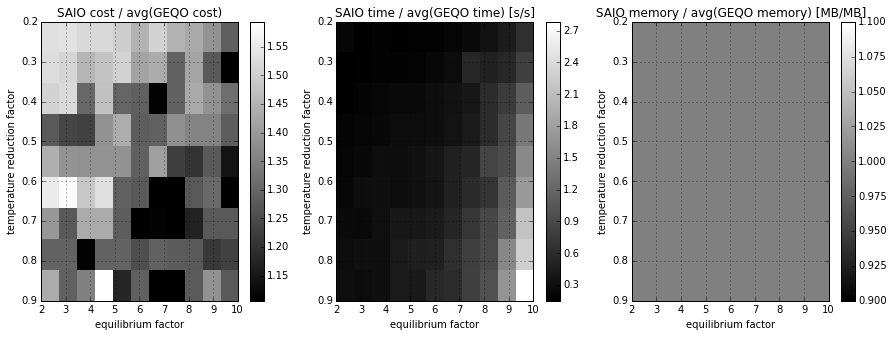

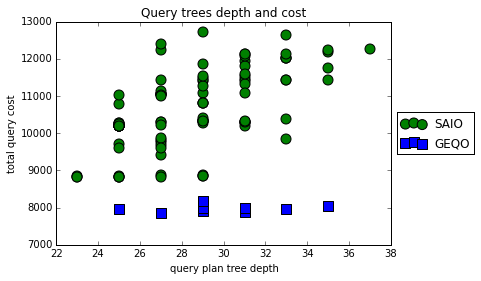

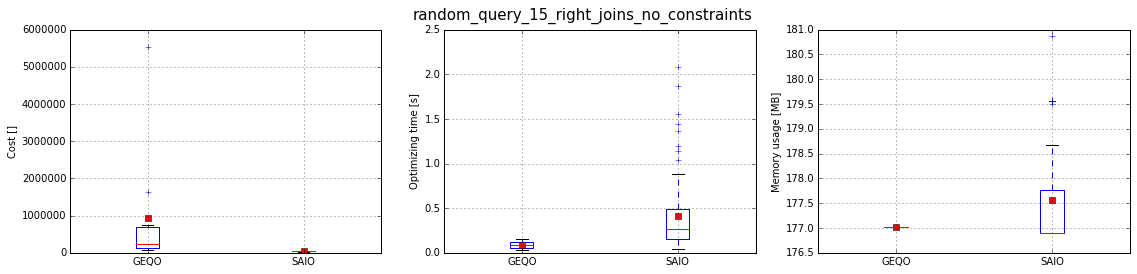

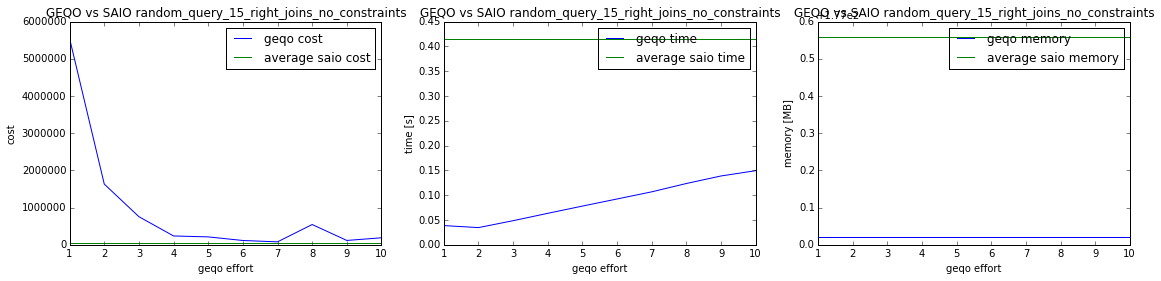

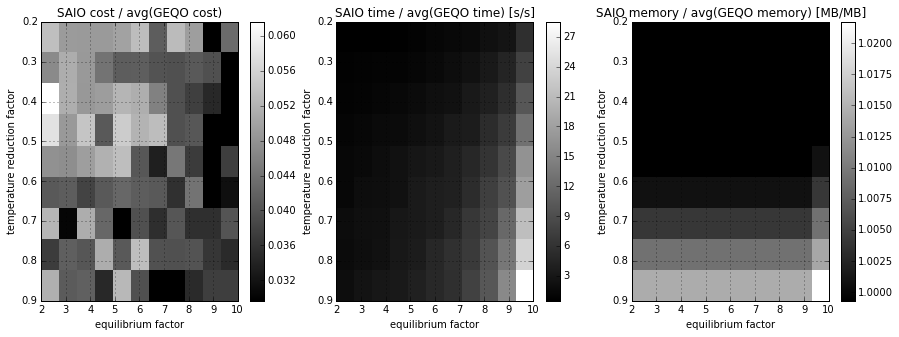

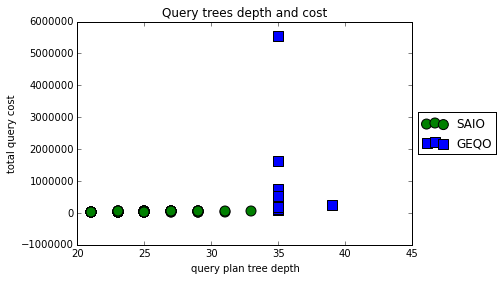

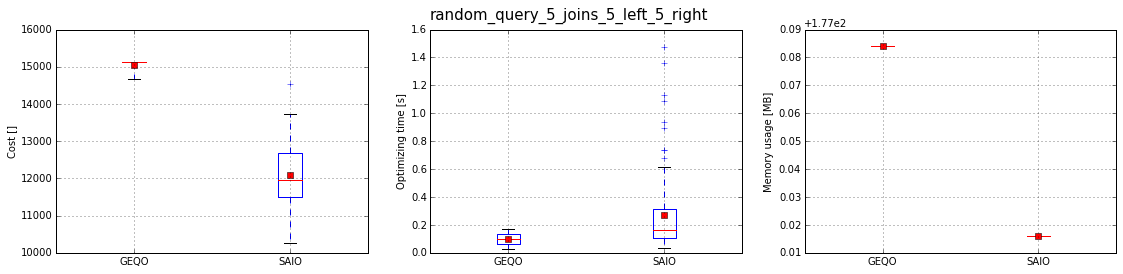

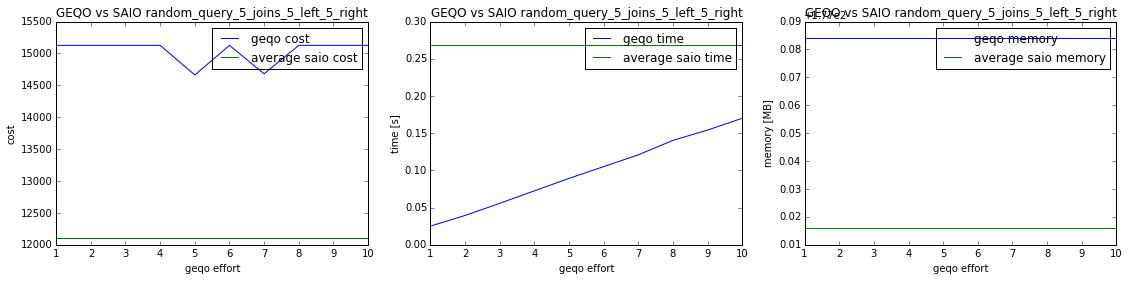

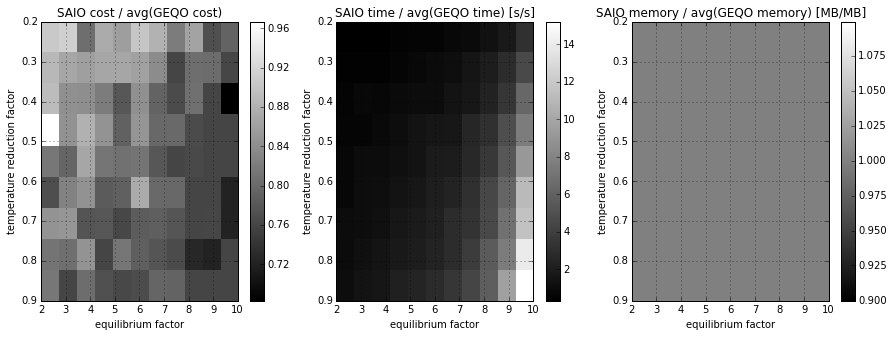

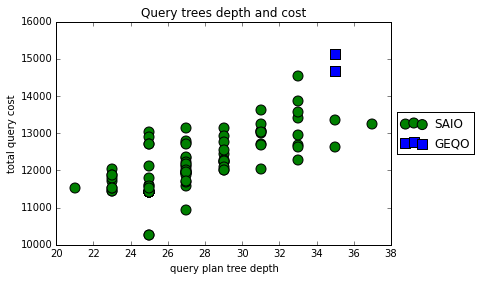

In [28]:
display_info_for_test_case('random_query_15_joins_no_constraints')
display_info_for_test_case('random_query_15_left_joins_no_constraints')
display_info_for_test_case('random_query_15_right_joins_no_constraints')
display_info_for_test_case('random_query_5_joins_5_left_5_right')

####20 JOINS

For these queries the observations from the previous smaller queries hold. 
SAIO seems comparable to GEQO for queries with regular JOINS, worse for queries with LEFT JOINS and much better (correct!) for queries with RIGHT JOINS and mixed queries.

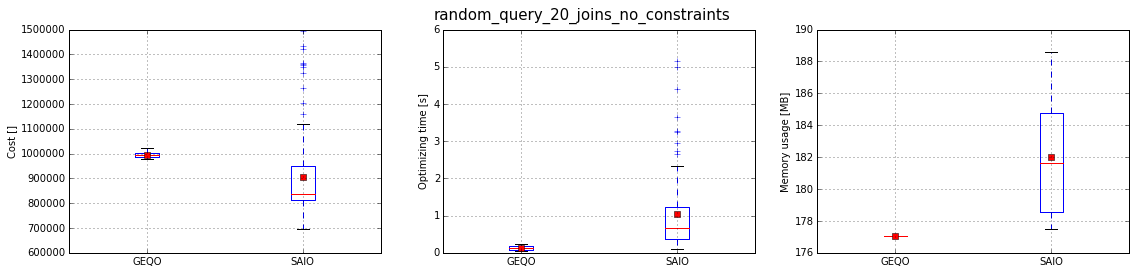

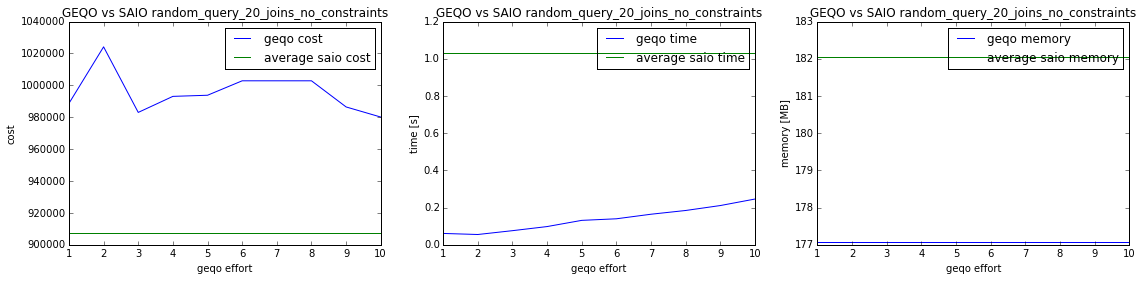

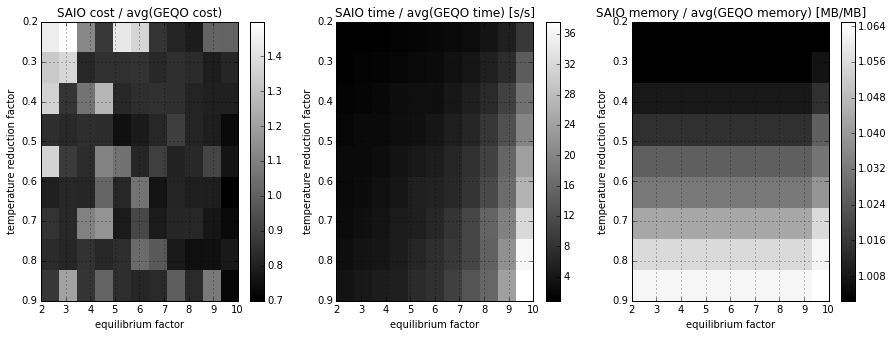

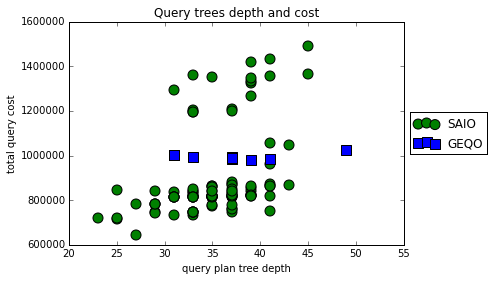

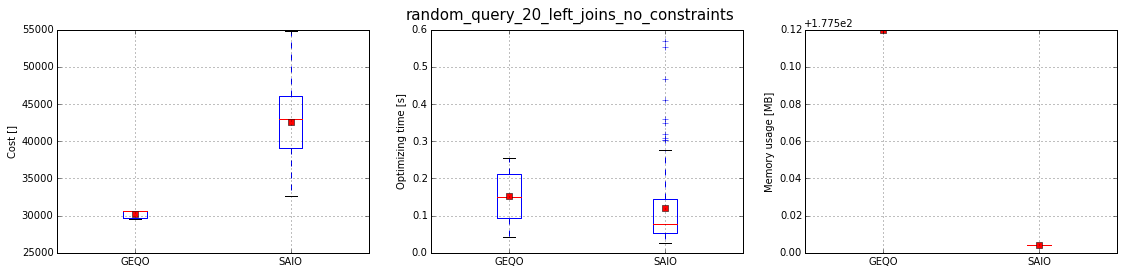

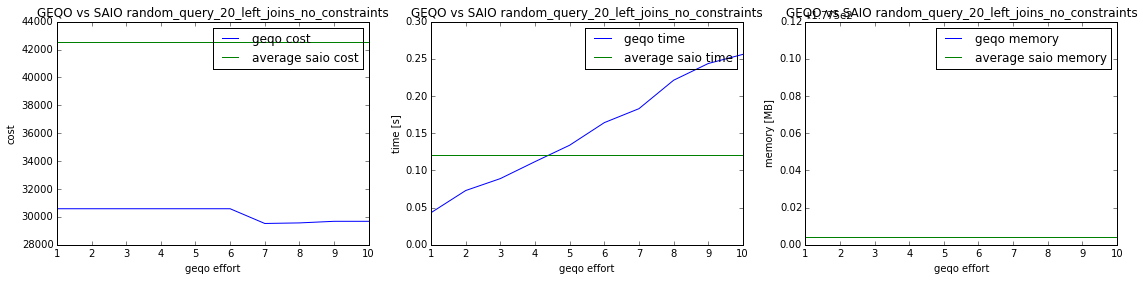

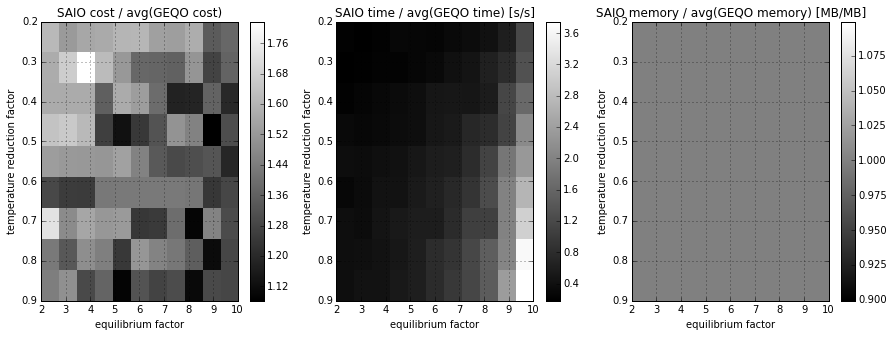

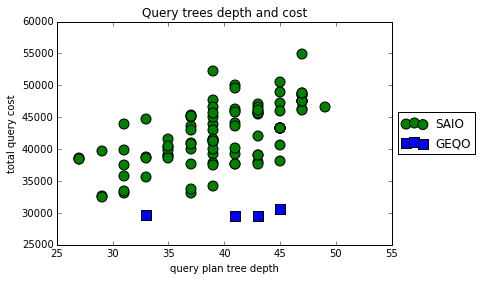

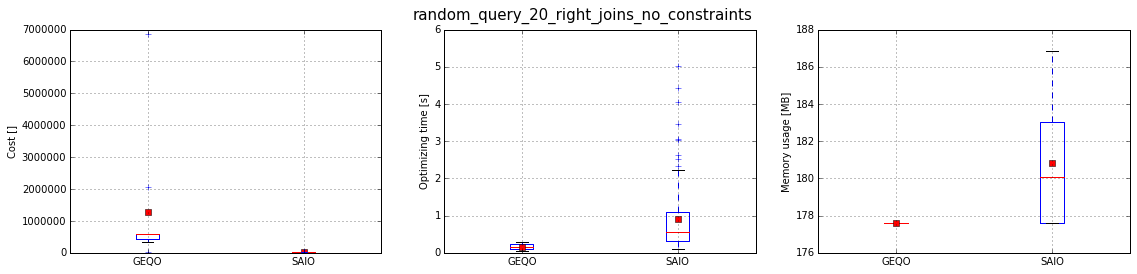

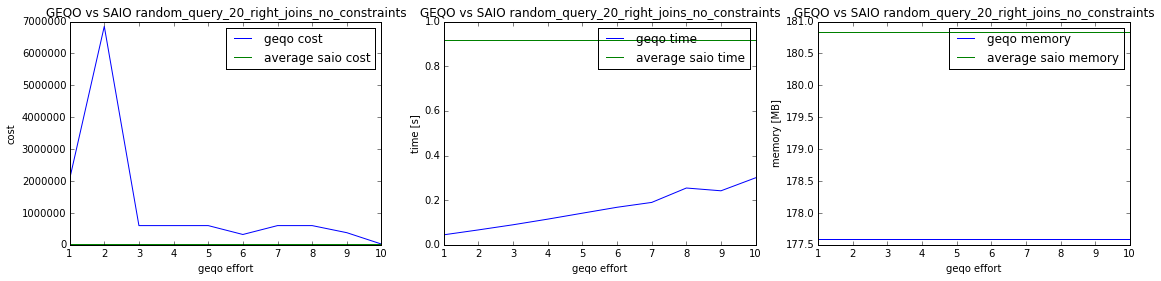

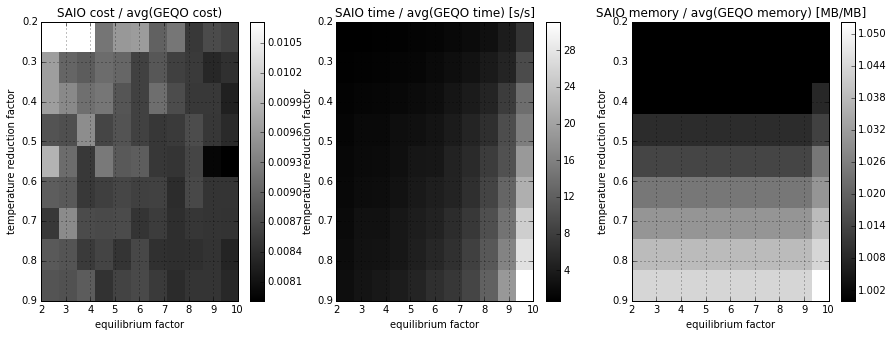

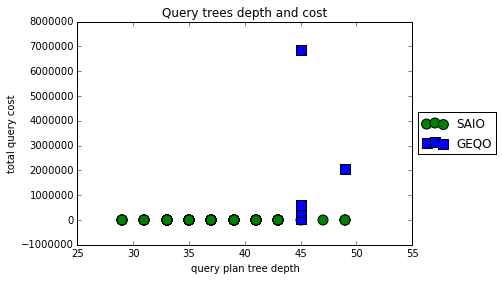

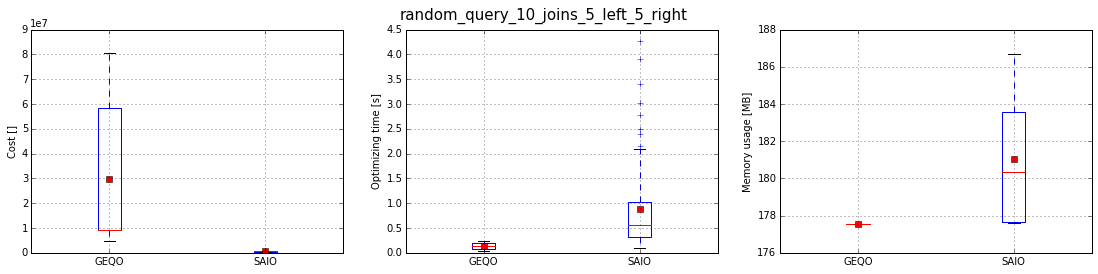

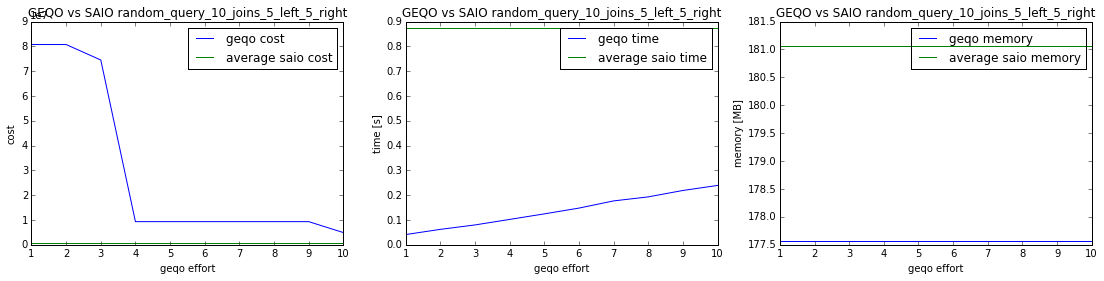

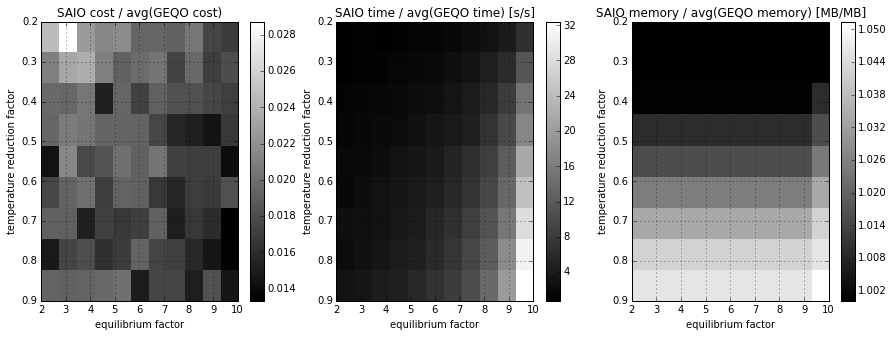

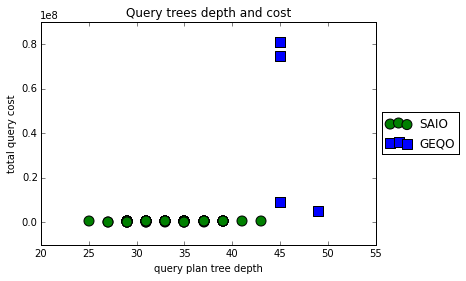

In [21]:
display_info_for_test_case('random_query_20_joins_no_constraints')
display_info_for_test_case('random_query_20_left_joins_no_constraints')
display_info_for_test_case('random_query_20_right_joins_no_constraints')
display_info_for_test_case('random_query_10_joins_5_left_5_right')

####30 JOINS

The observations from previous cases of flat queries hold.

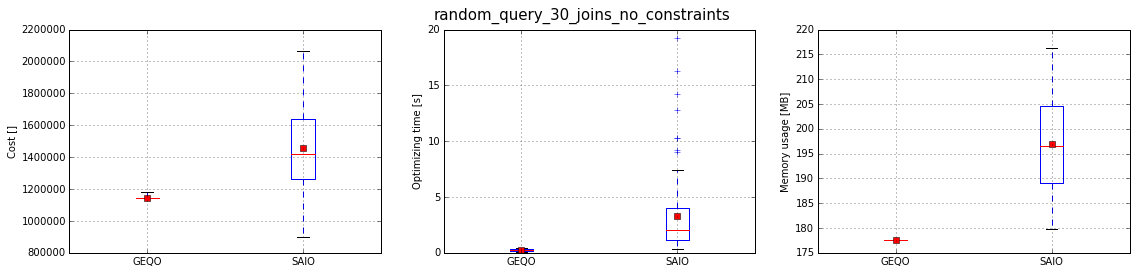

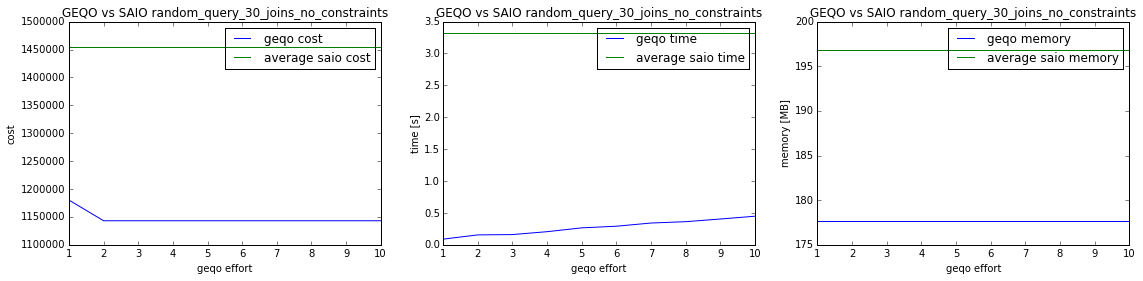

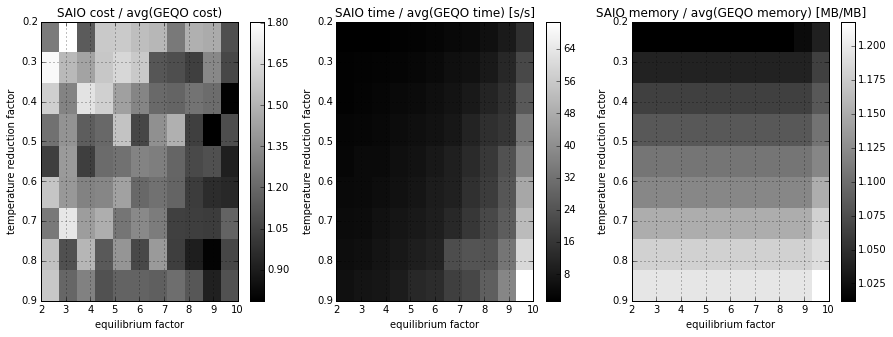

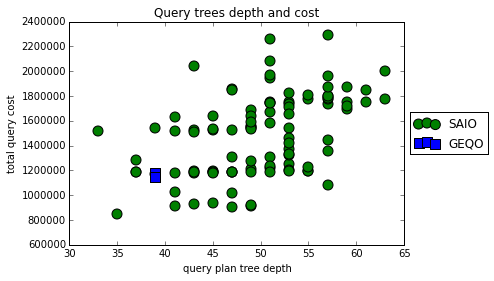

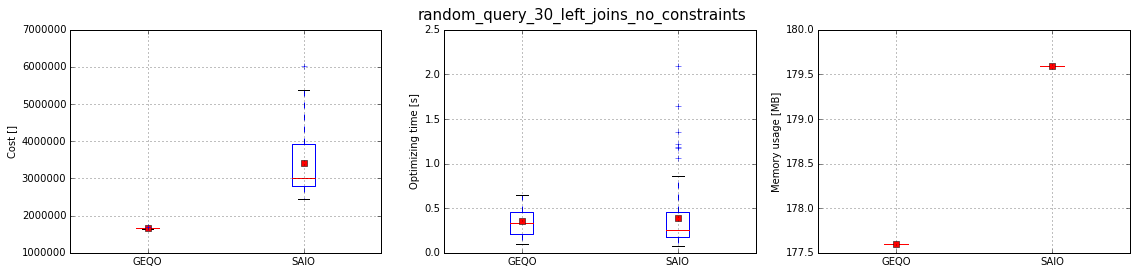

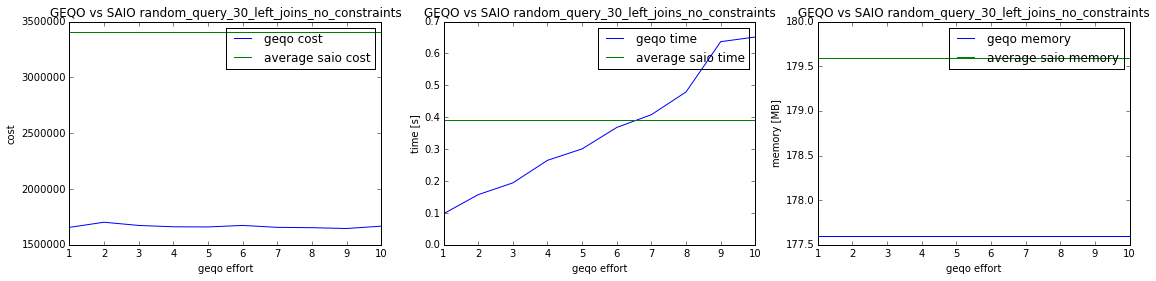

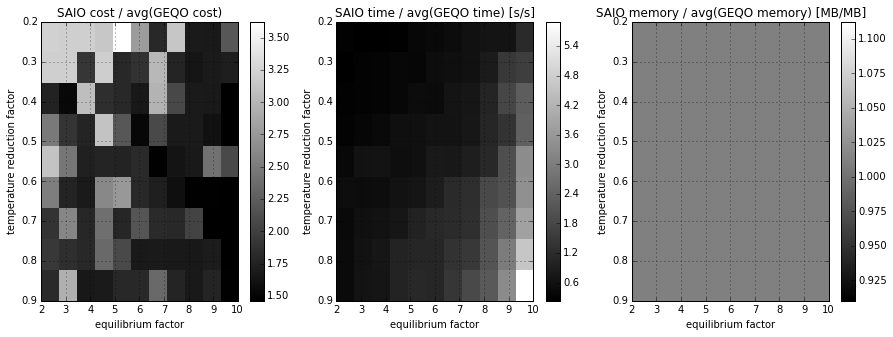

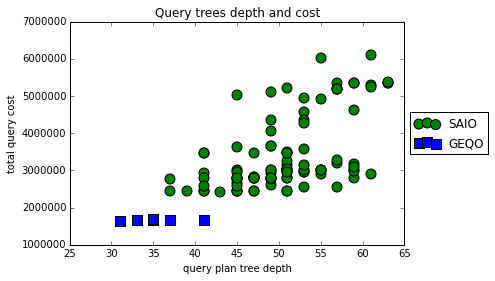

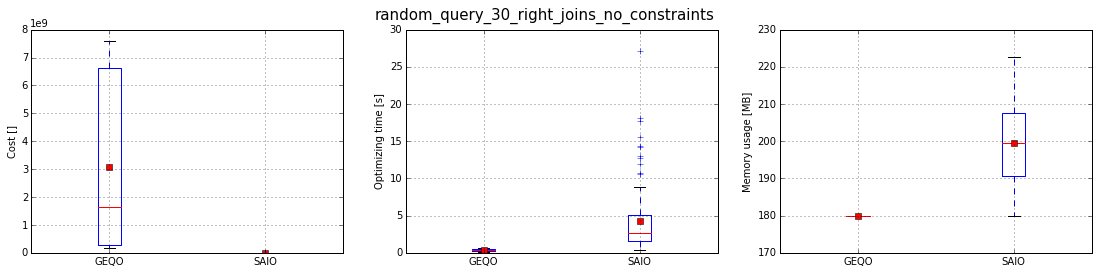

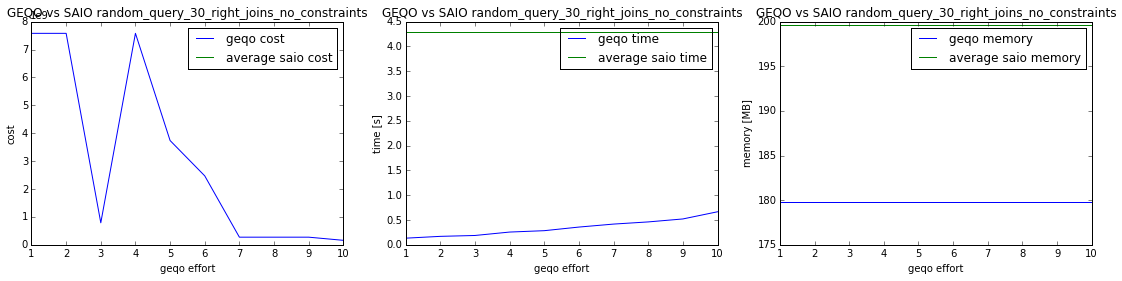

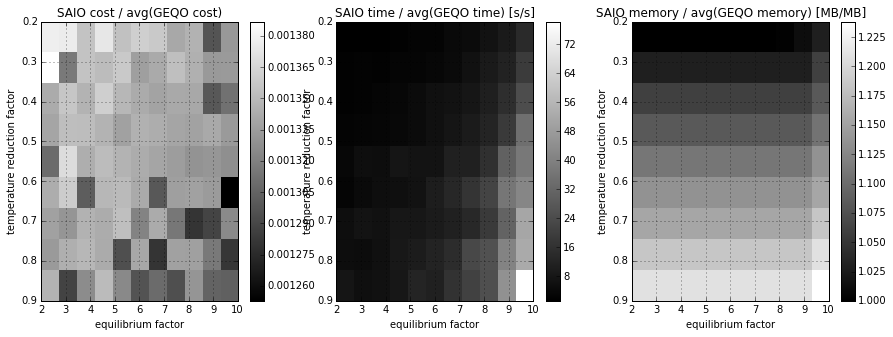

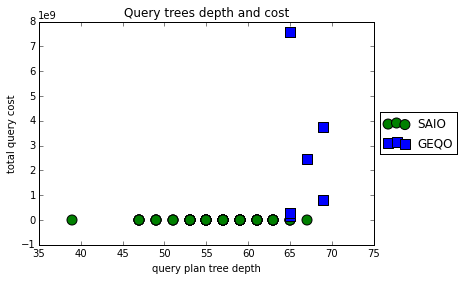

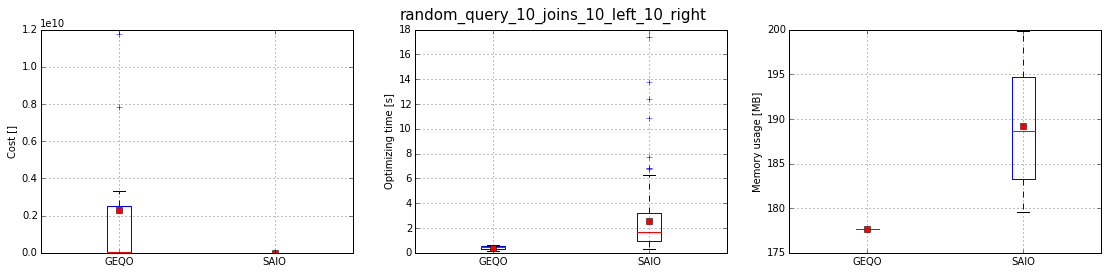

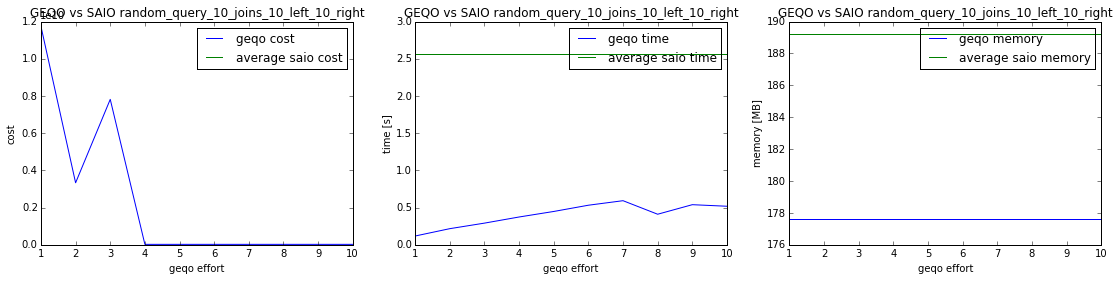

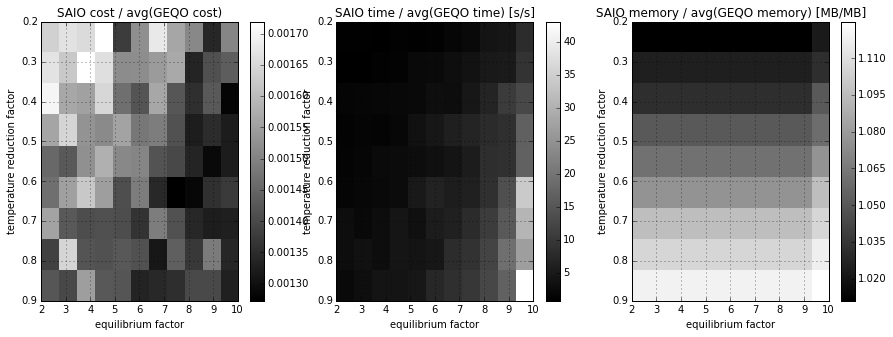

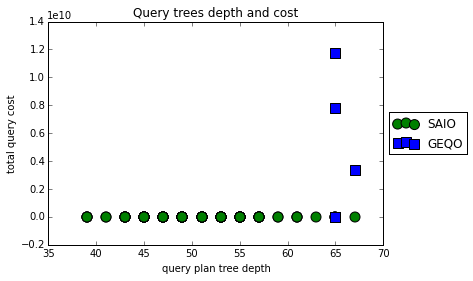

In [22]:
display_info_for_test_case('random_query_30_joins_no_constraints')
display_info_for_test_case('random_query_30_left_joins_no_constraints')
display_info_for_test_case('random_query_30_right_joins_no_constraints')
display_info_for_test_case('random_query_10_joins_10_left_10_right')

####50 JOINS

For the next part of flat queries, this time with 50 JOINS, we can see that GEQO produces better results for queries with JOINS and LEFT JOINS. 

SAIO wins at RIGHT JOIN cases and mixed queries.

This is interesting that for the query with 50 LEFT JOINS GEQO actually produces a shorter tree than SAIO solutions.

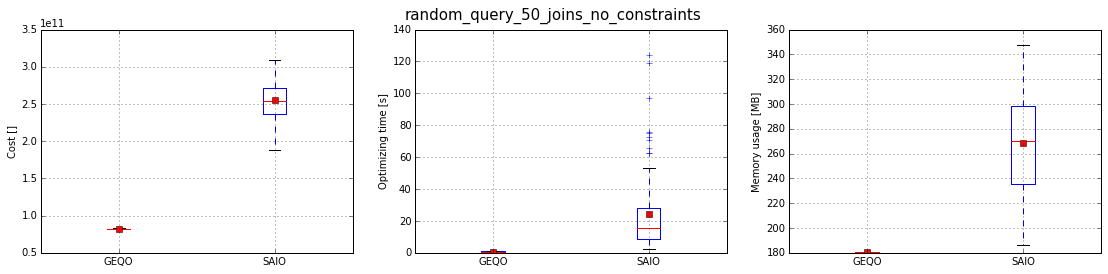

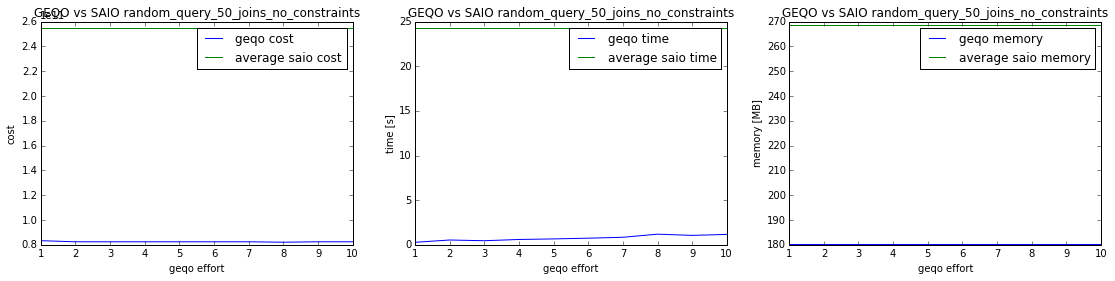

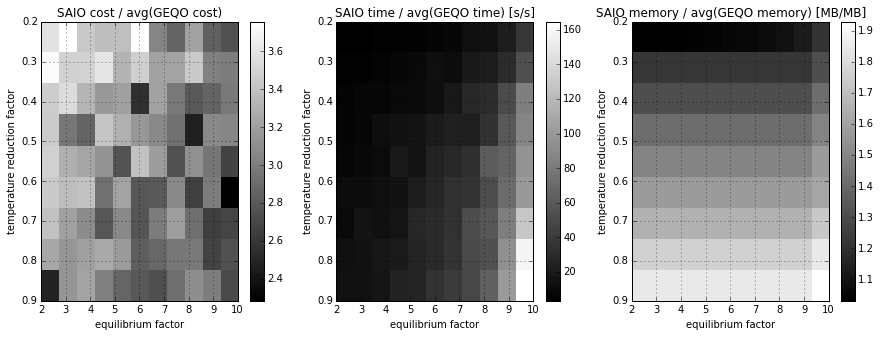

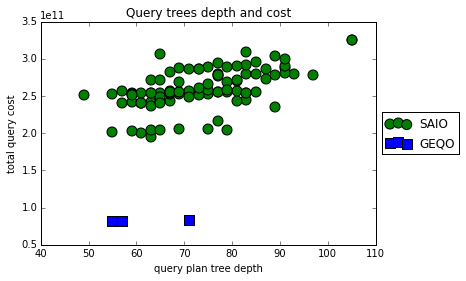

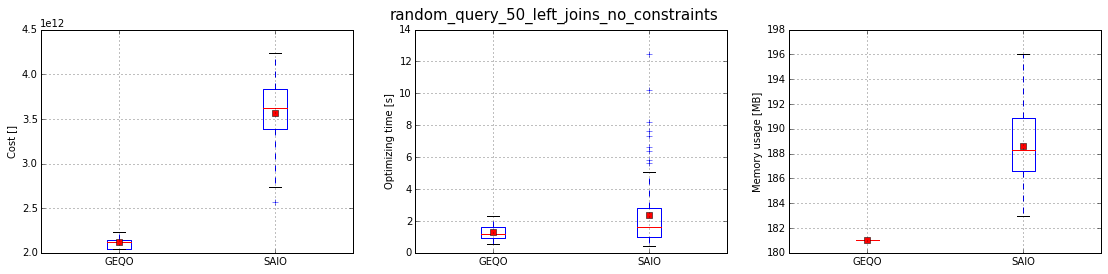

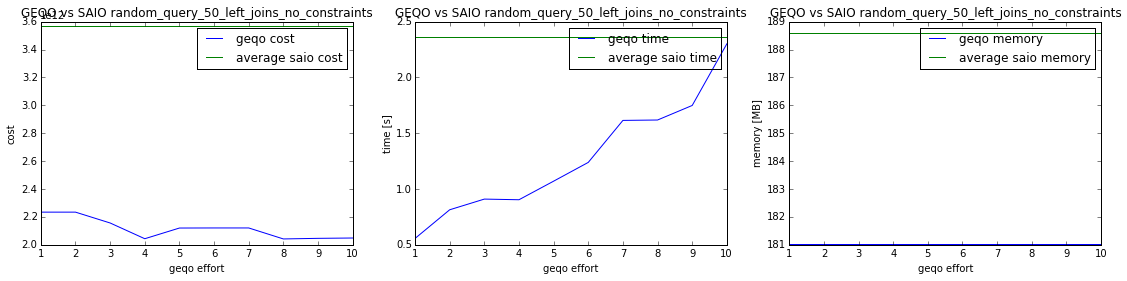

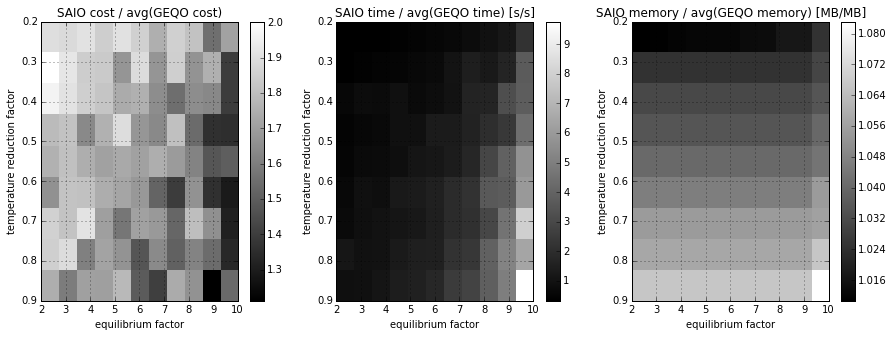

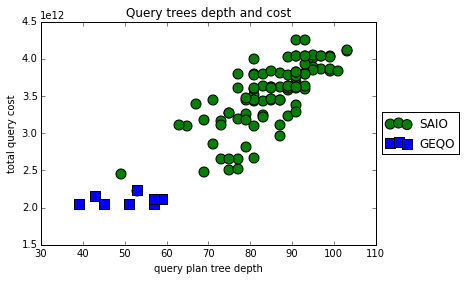

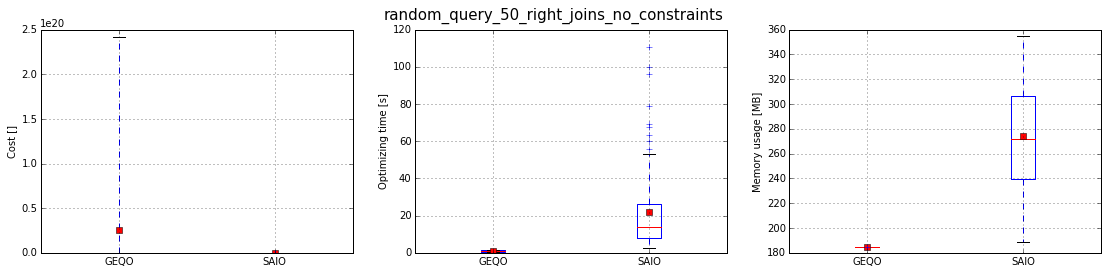

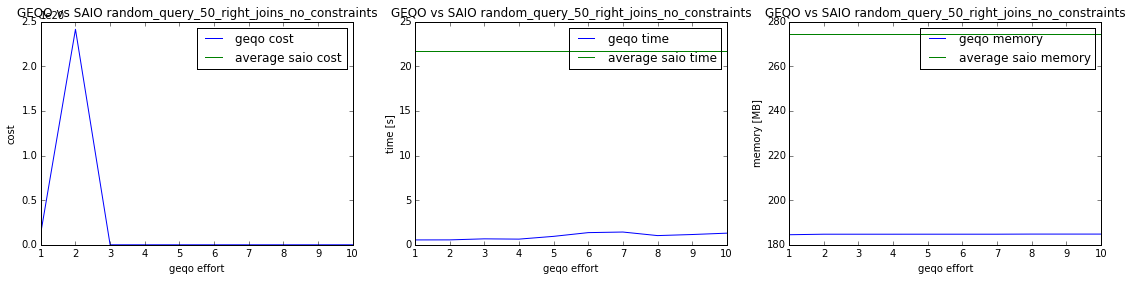

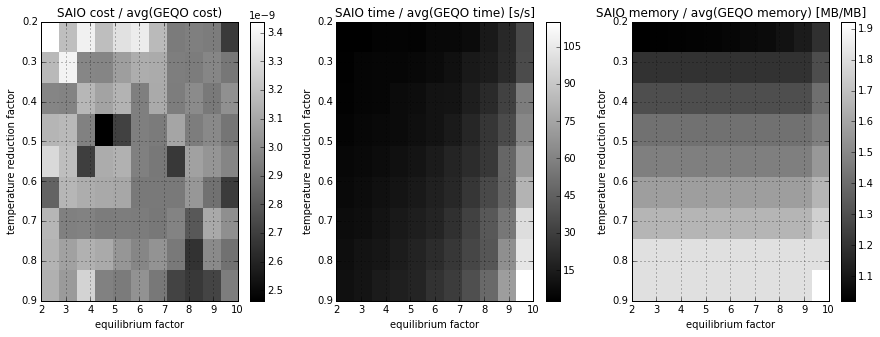

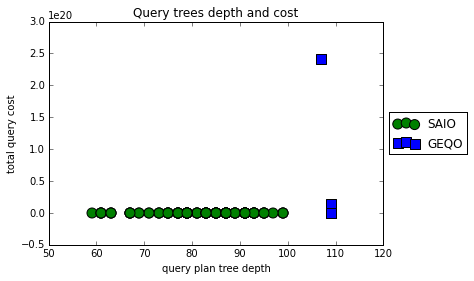

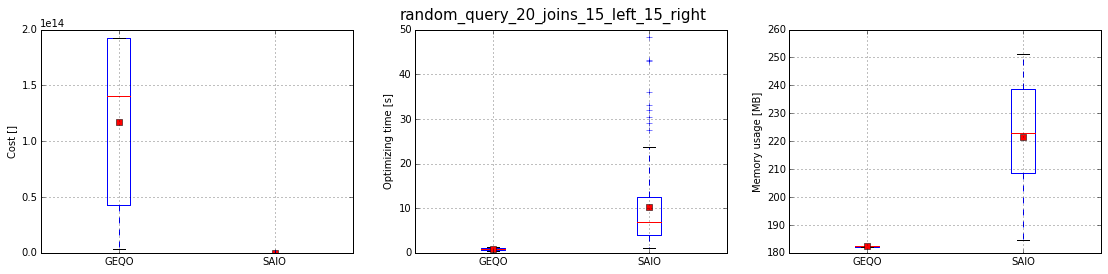

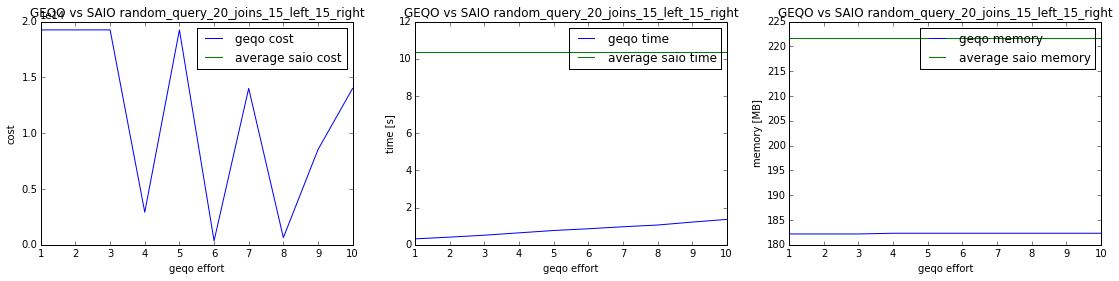

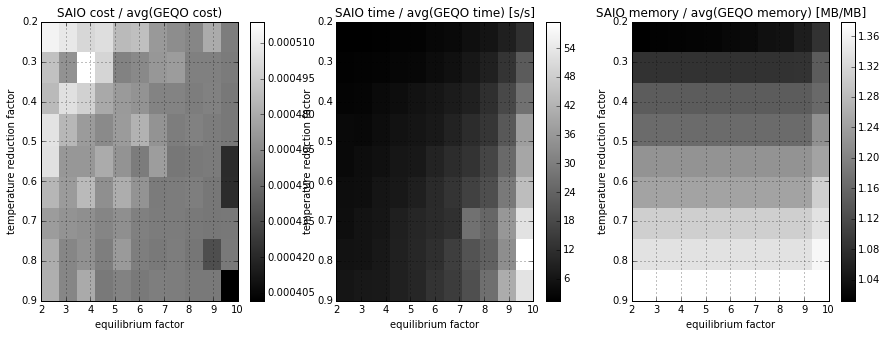

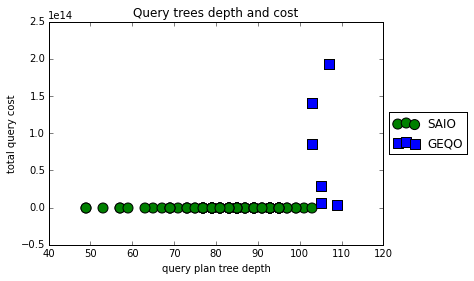

In [23]:
display_info_for_test_case('random_query_50_joins_no_constraints')
display_info_for_test_case('random_query_50_left_joins_no_constraints')
display_info_for_test_case('random_query_50_right_joins_no_constraints')
display_info_for_test_case('random_query_20_joins_15_left_15_right')

####70 JOINS

Observations from the previous case hold.

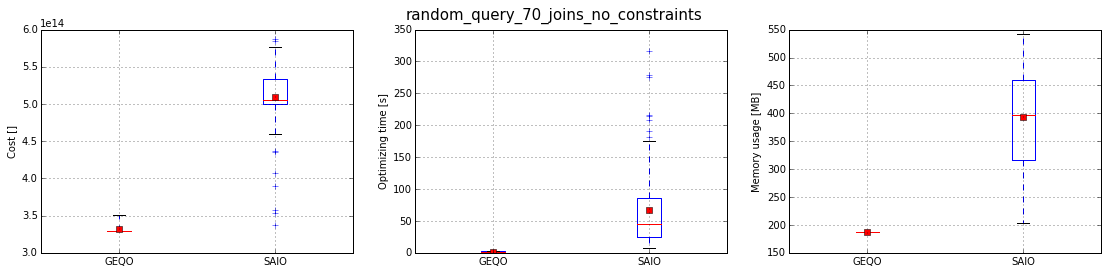

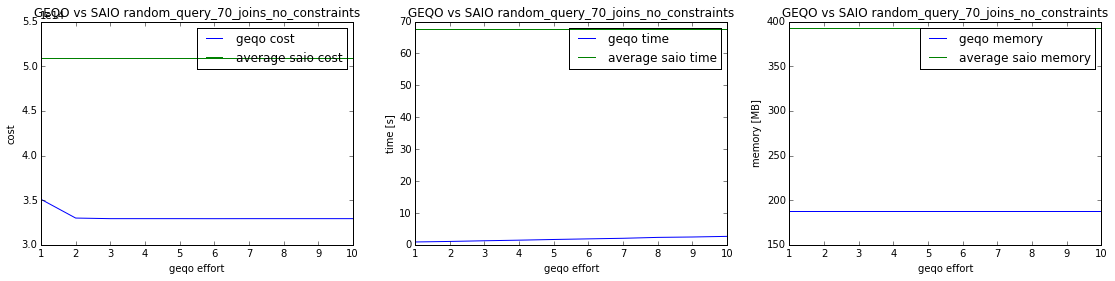

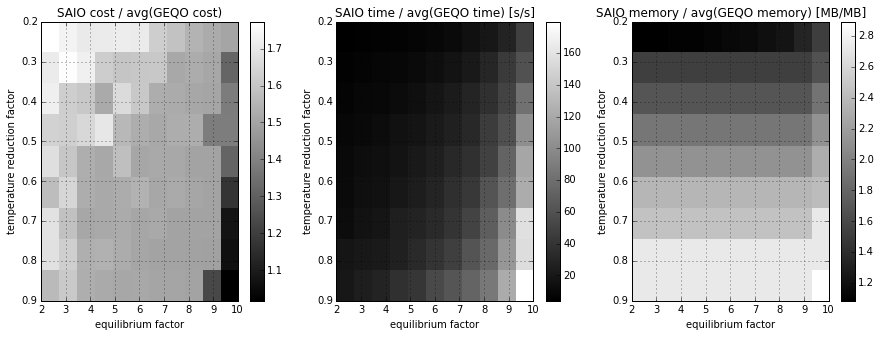

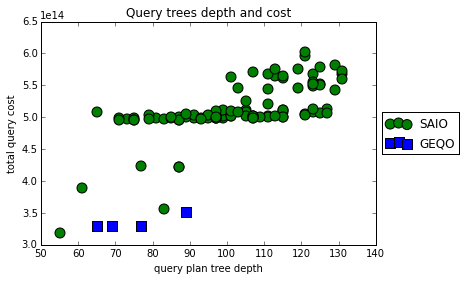

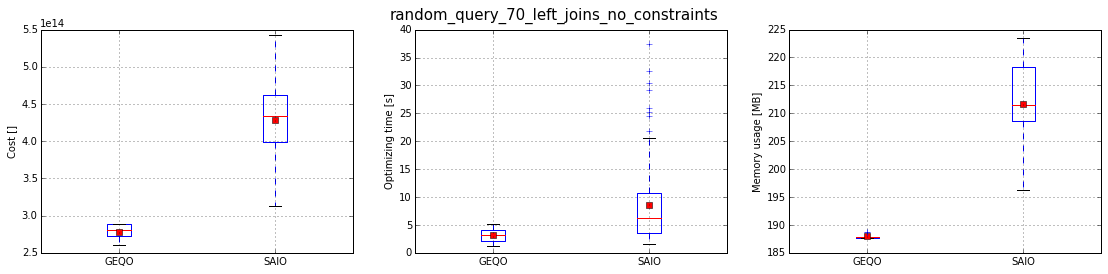

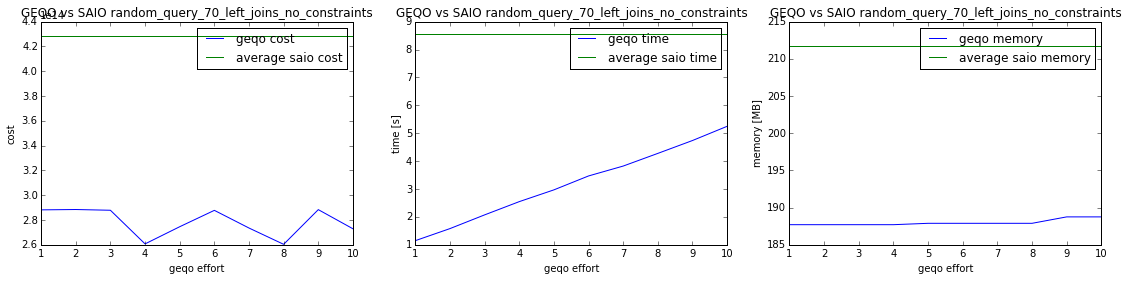

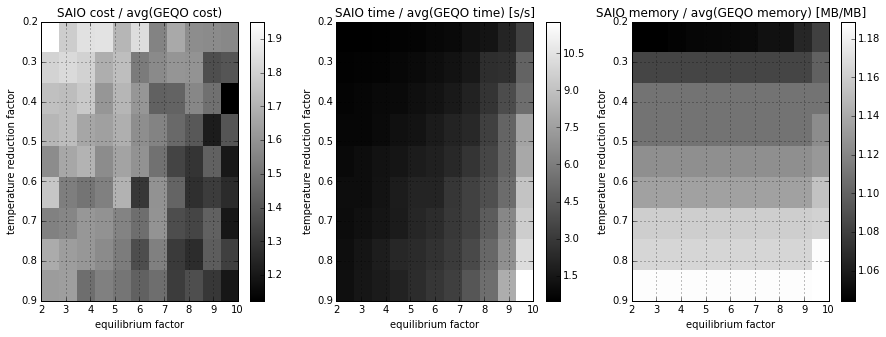

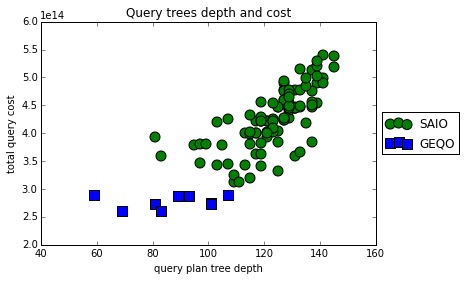

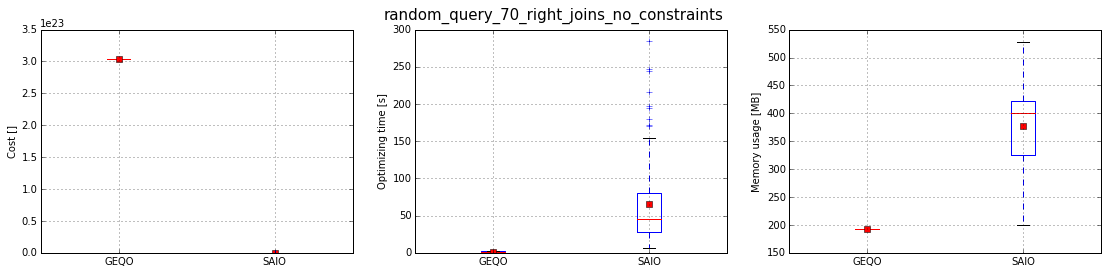

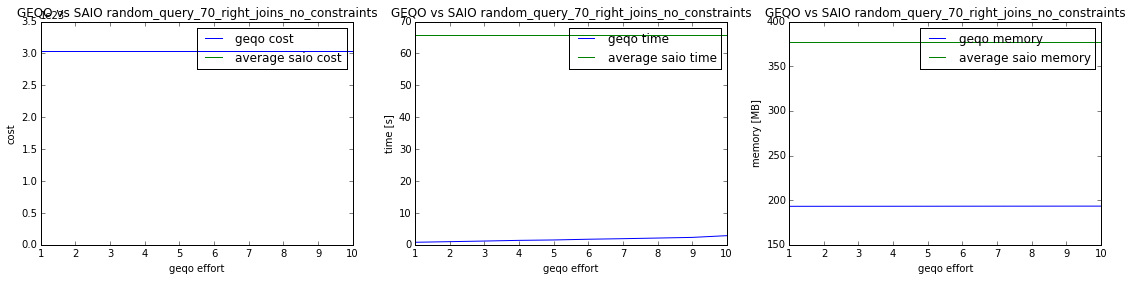

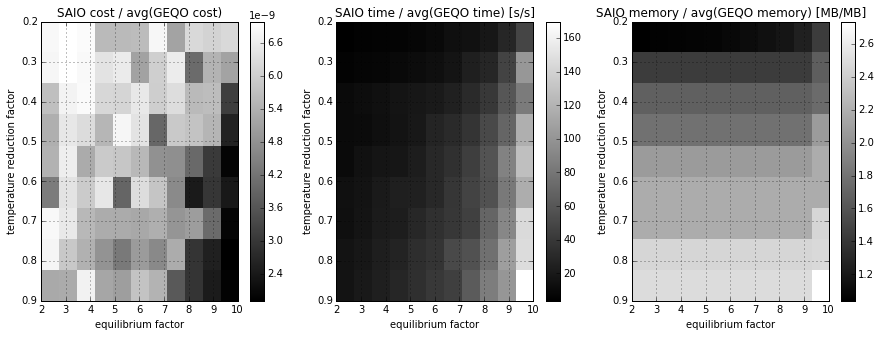

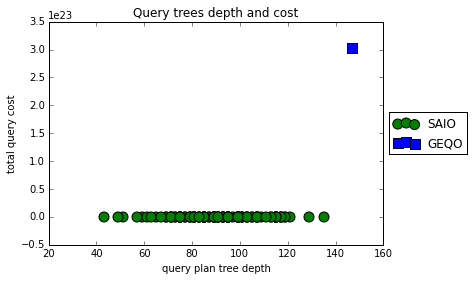

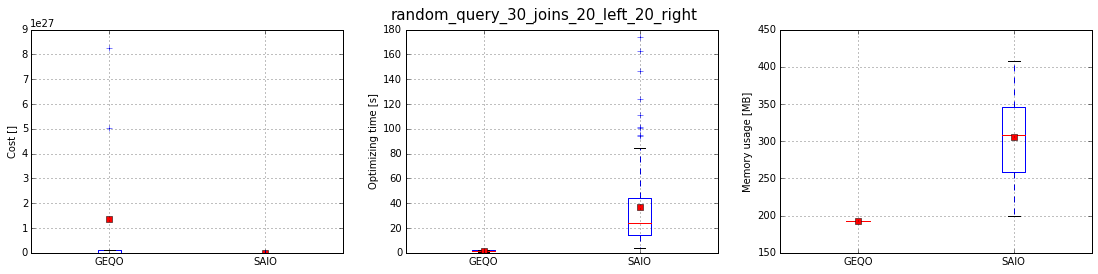

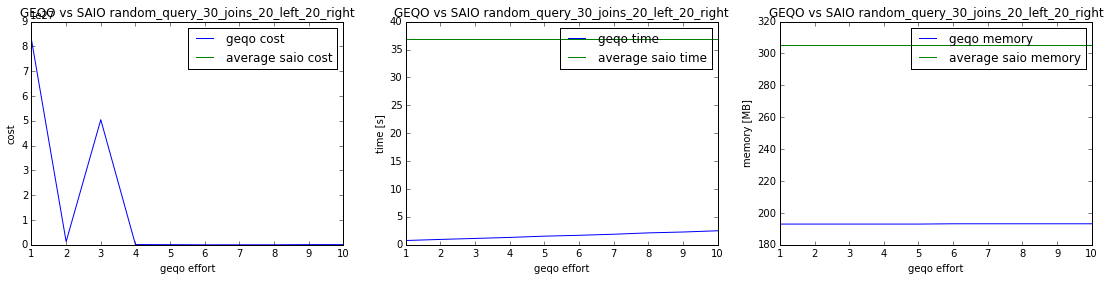

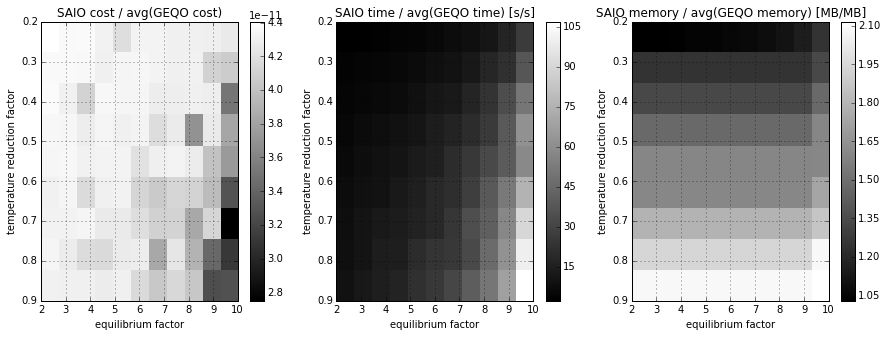

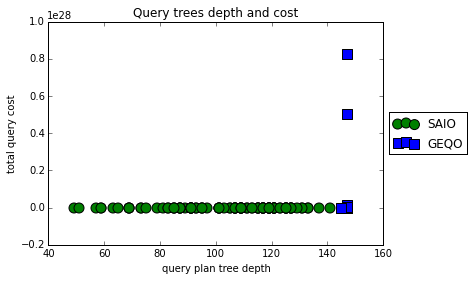

In [24]:
display_info_for_test_case('random_query_70_joins_no_constraints')
display_info_for_test_case('random_query_70_left_joins_no_constraints')
display_info_for_test_case('random_query_70_right_joins_no_constraints')
display_info_for_test_case('random_query_30_joins_20_left_20_right')

####100 JOINS

These queries would probably not complete during our lifetime, however the observations from the previous cases hold.

GEQO wins for JOINS and LEFT JOINS, SAIO wins for queries that contain RIGHT JOINS.

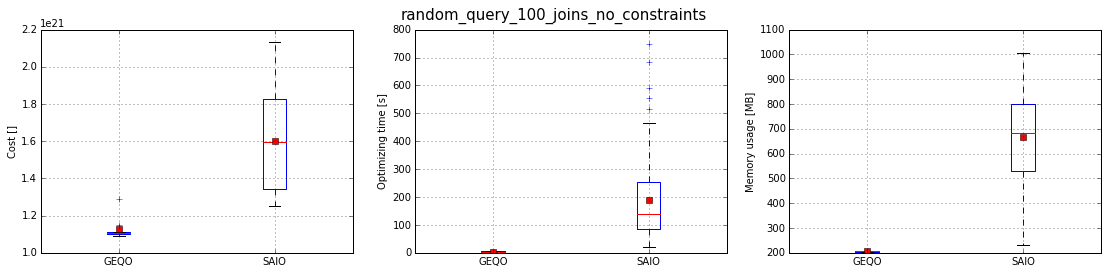

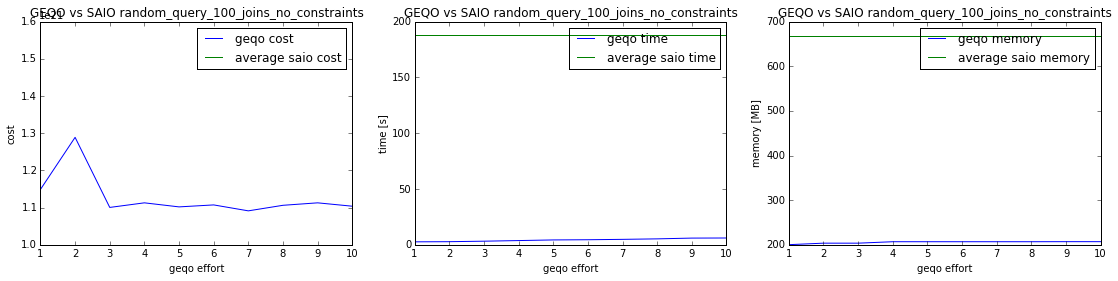

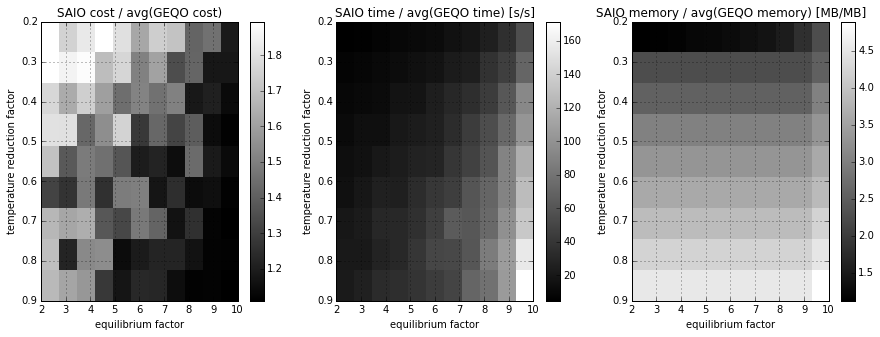

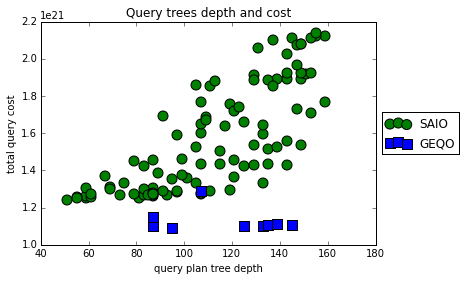

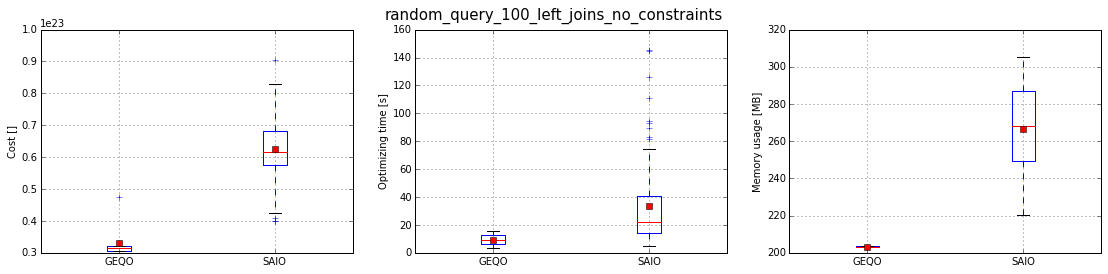

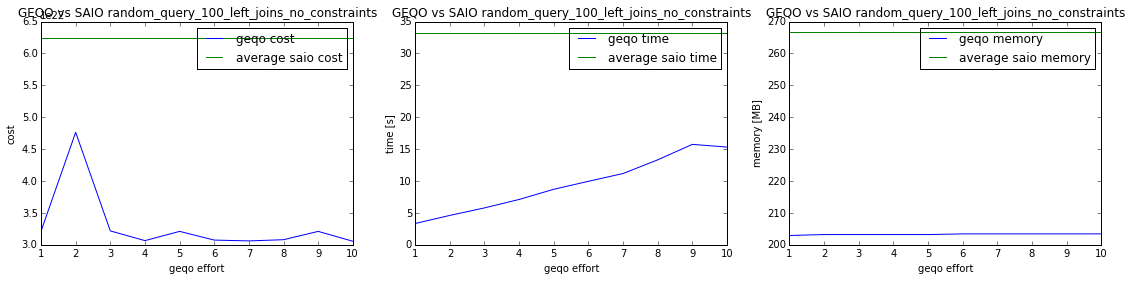

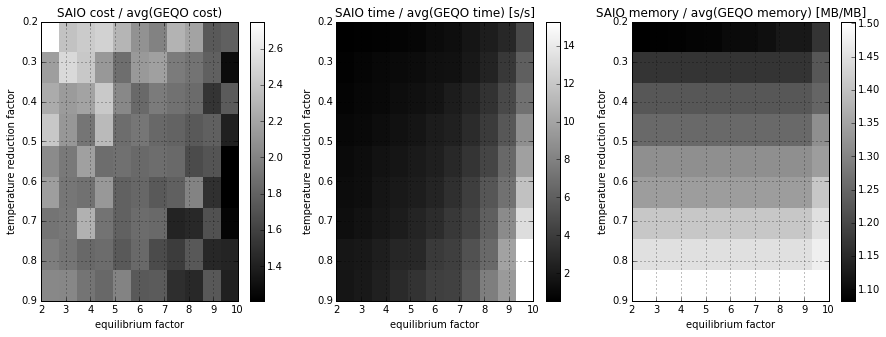

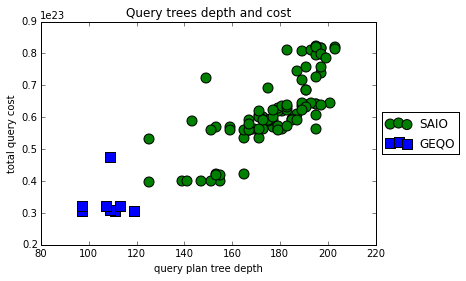

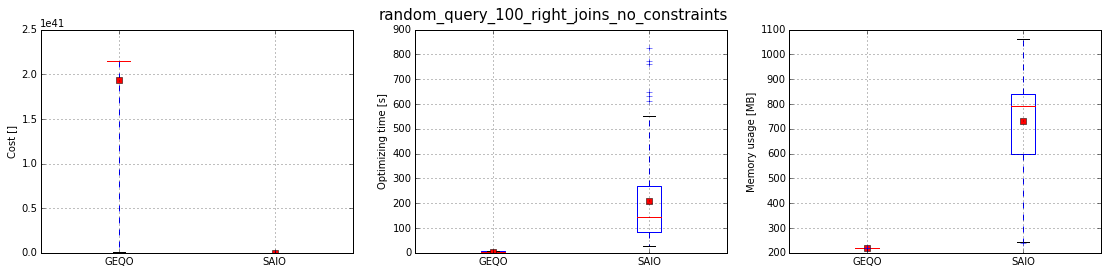

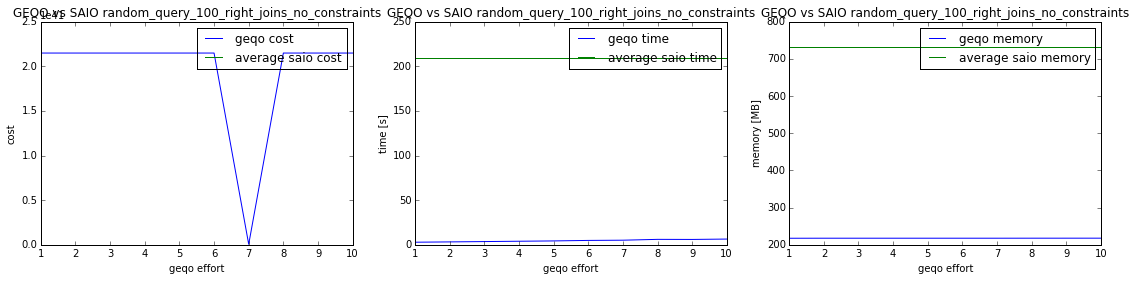

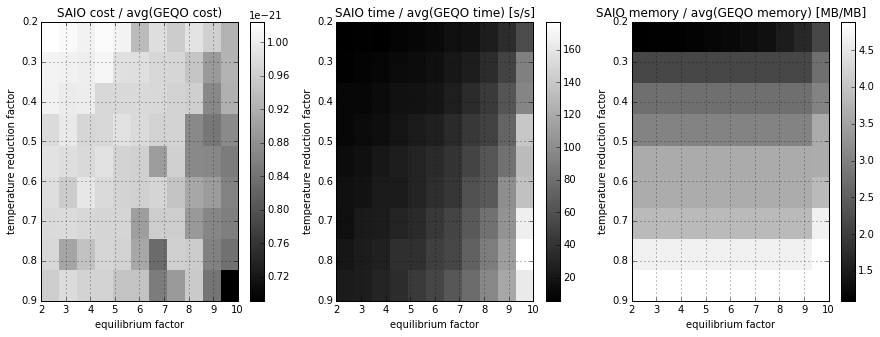

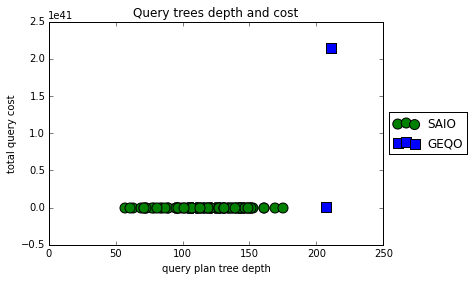

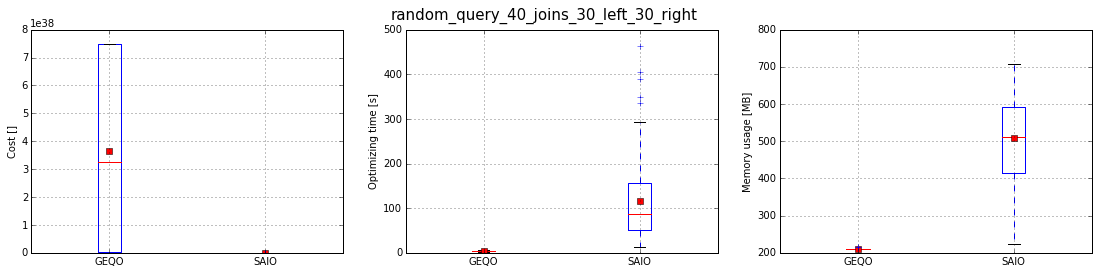

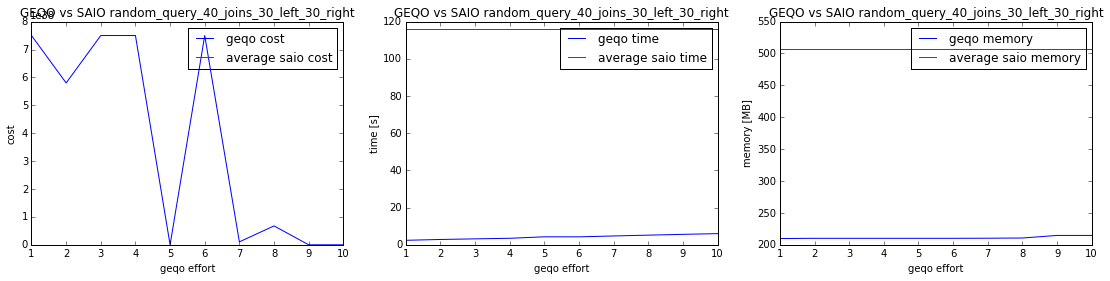

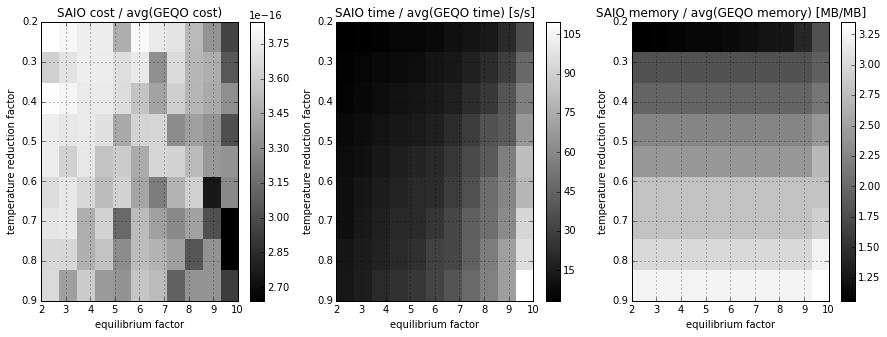

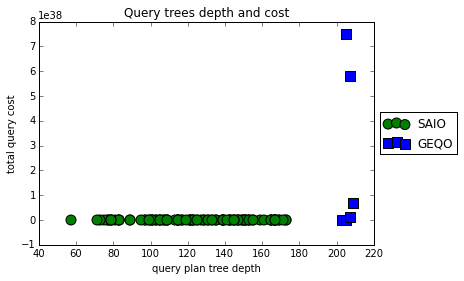

In [52]:
display_info_for_test_case('random_query_100_joins_no_constraints')
display_info_for_test_case('random_query_100_left_joins_no_constraints')
display_info_for_test_case('random_query_100_right_joins_no_constraints')
display_info_for_test_case('random_query_40_joins_30_left_30_right')

####130 joins

Previous observations hold.

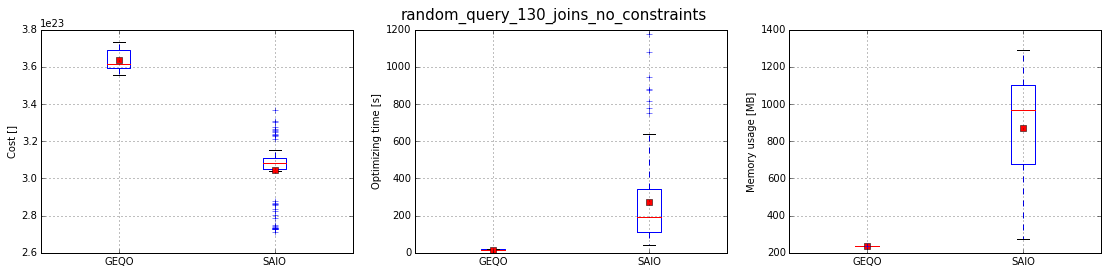

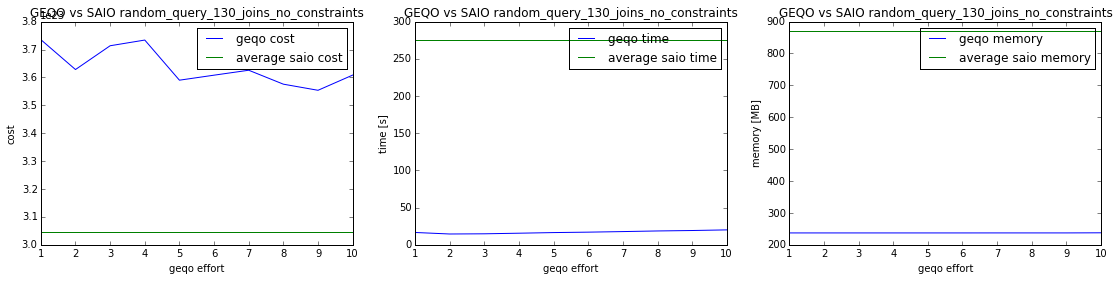

99


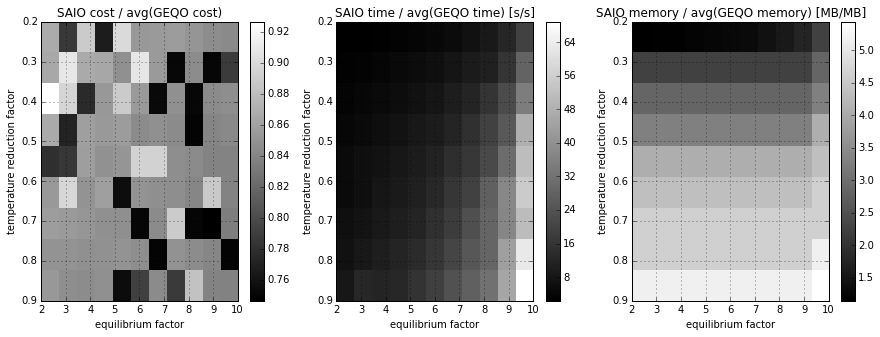

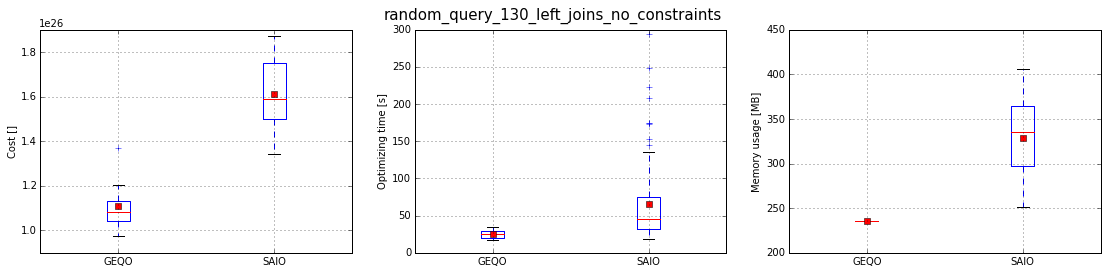

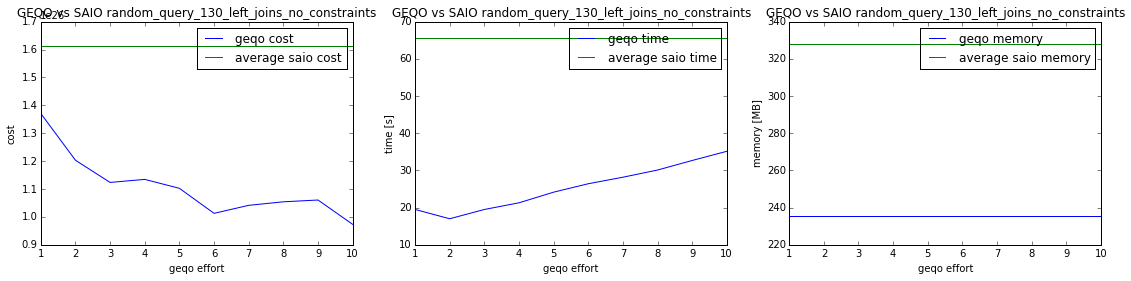

99


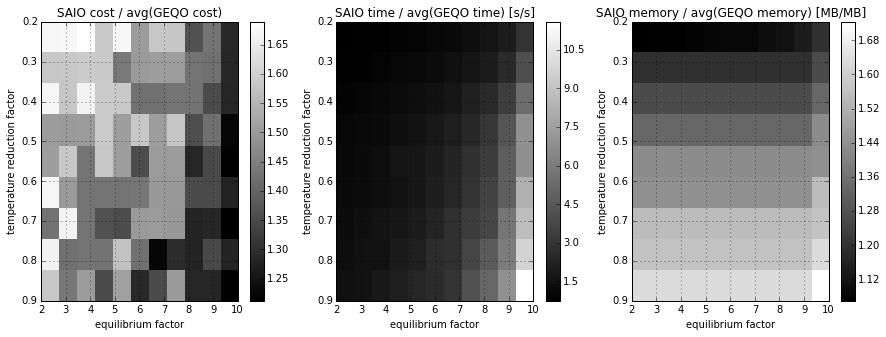

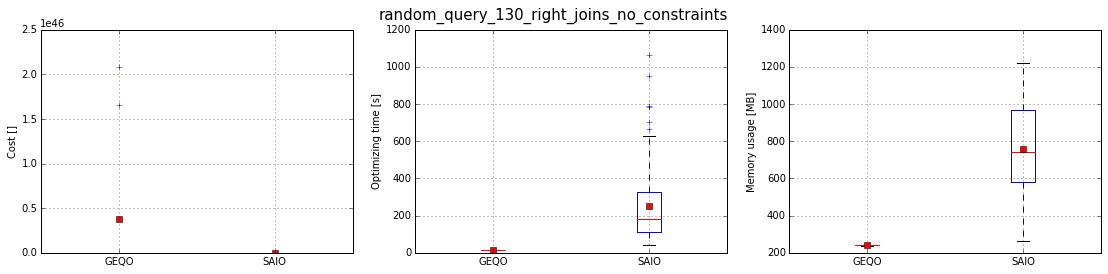

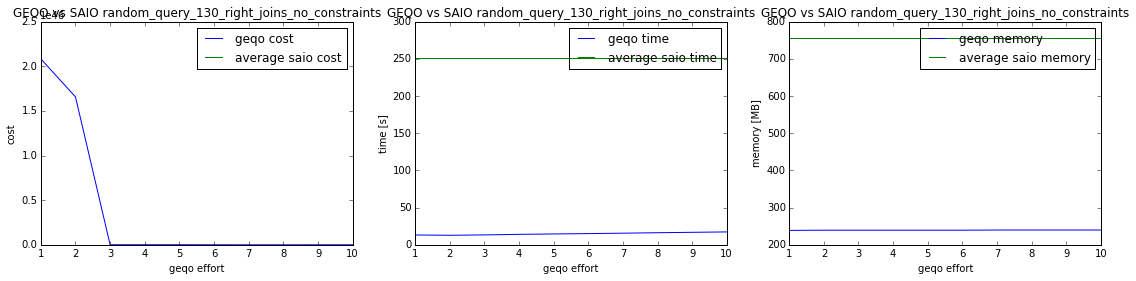

99


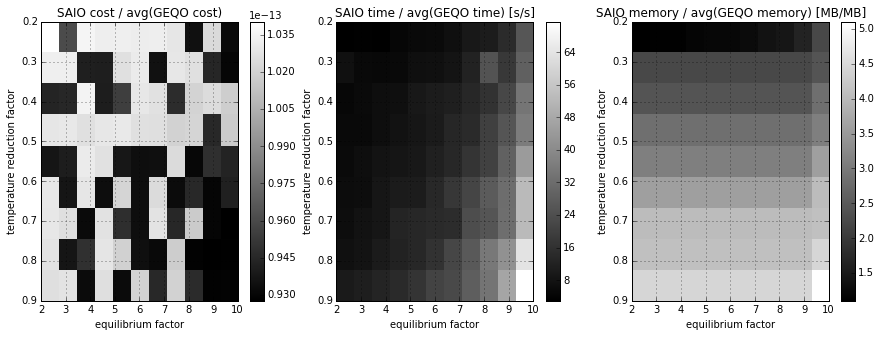

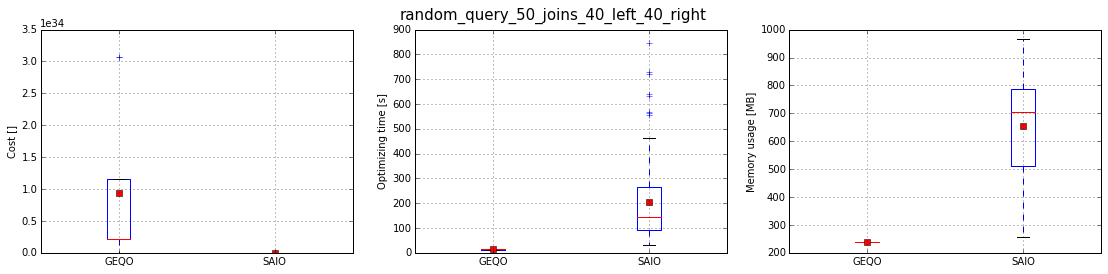

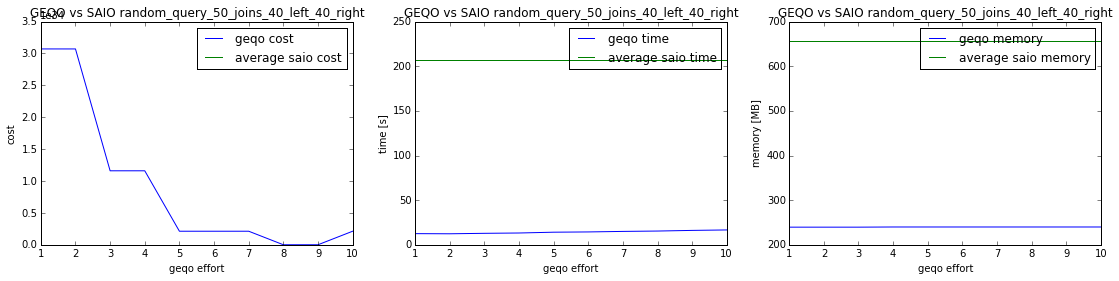

99


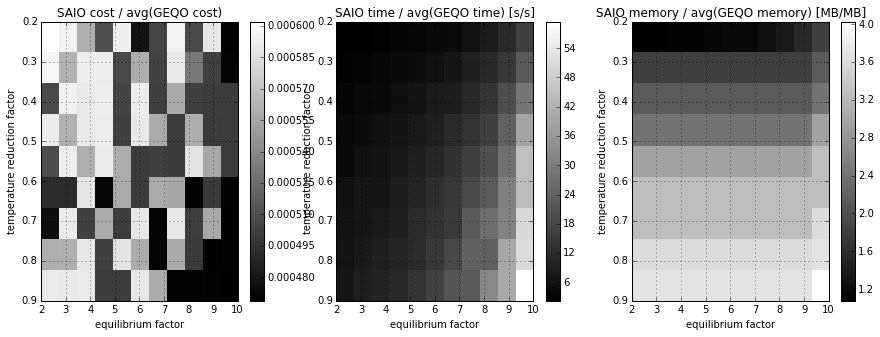

In [16]:
display_info_for_test_case('random_query_130_joins_no_constraints')
display_info_for_test_case('random_query_130_left_joins_no_constraints')
display_info_for_test_case('random_query_130_right_joins_no_constraints')
display_info_for_test_case('random_query_50_joins_40_left_40_right')

### nested queries
Example:

```sql
SELECT * FROM  table_0  JOIN table_12 ON table_0.col_0 = table_12.col_3
 JOIN table_11 ON table_12.col_1 = table_11.col_0
 JOIN table_5 ON table_0.col_1 = table_5.col_1
 JOIN table_13 ON table_0.col_0 = table_13.col_1
 JOIN table_7 ON table_12.col_3 = table_7.col_1
 JOIN table_8 ON table_11.col_0 = table_8.col_0
 JOIN table_19 ON table_12.col_3 = table_19.col_1
 JOIN table_3 ON table_12.col_1 = table_3.col_1
 JOIN table_1 ON table_0.col_3 = table_1.col_2
 JOIN table_17 ON table_5.col_1 = table_17.col_0
 JOIN (
     SELECT * FROM  table_0  JOIN table_5 ON table_0.col_1 = table_5.col_0
    ) AS subquery_table_0_299 
                    ON TRUE
 JOIN table_15 ON table_12.col_0 = table_15.col_2
 JOIN table_6 ON table_12.col_3 = table_6.col_0
 JOIN table_16 ON table_0.col_0 = table_16.col_0;

```

####15-20 JOINS

For nested queries with 15-20 JOINS we can observe similar situation as for flat queries with such parameters.

SAIO wins for queries that use JOINS or contain RIGHT JOINS. GEQO wins at optimizing queries with LEFT JOINS.

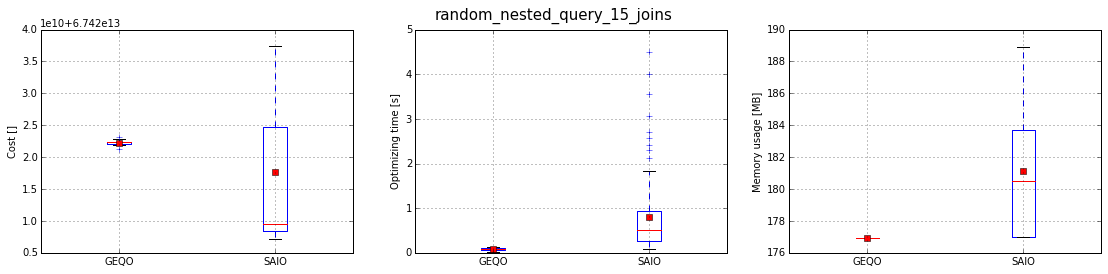

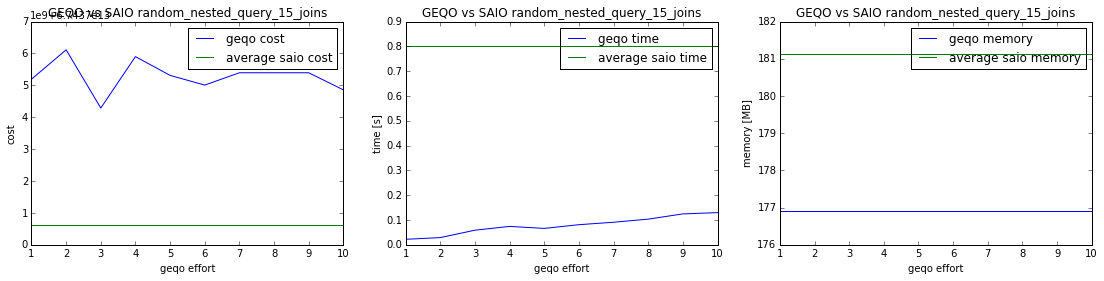

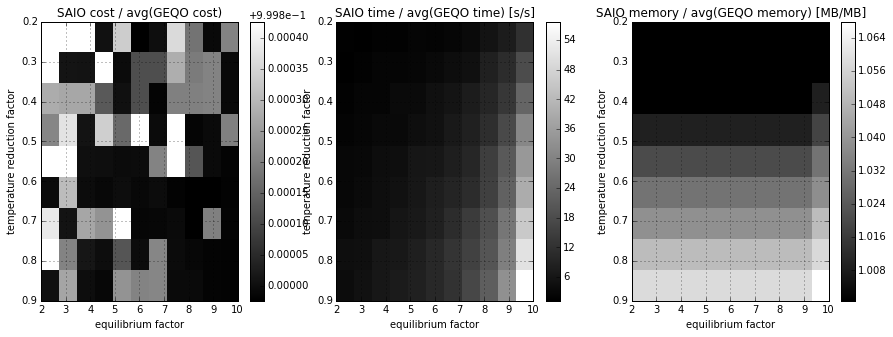

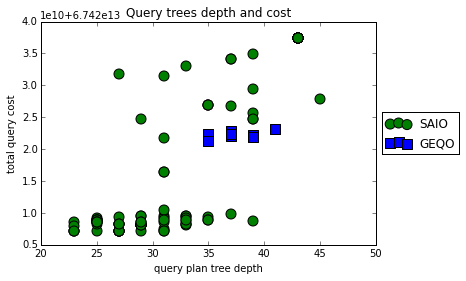

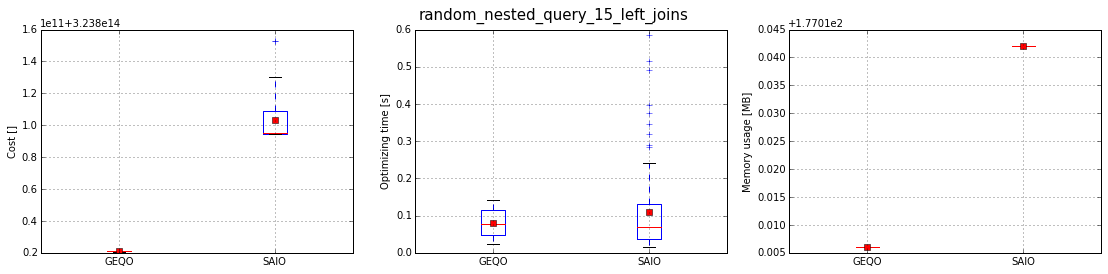

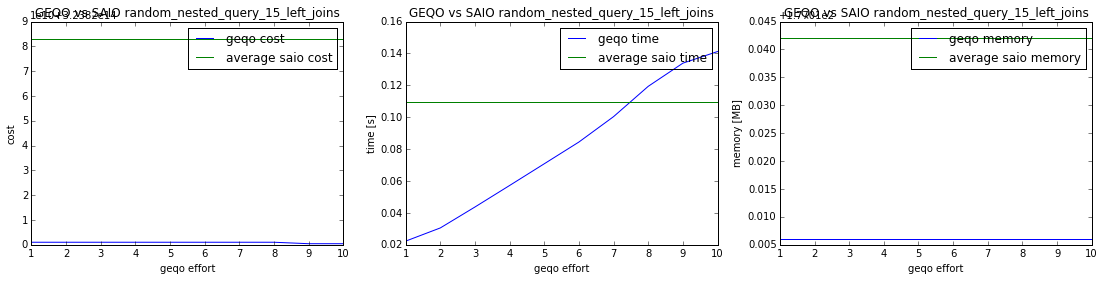

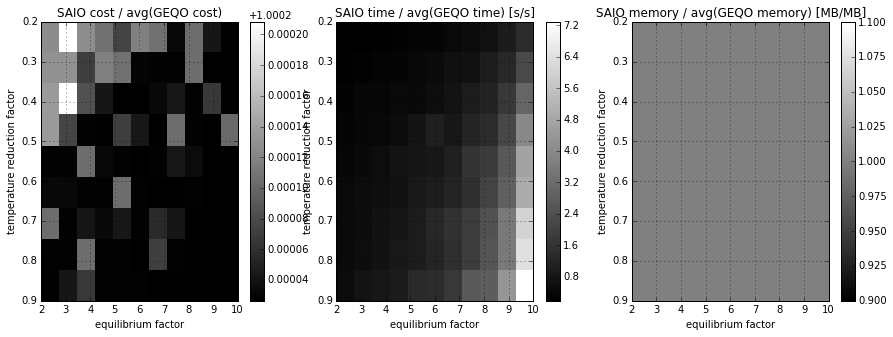

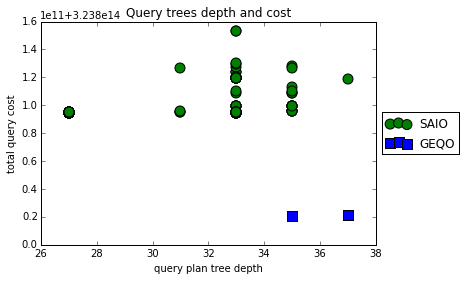

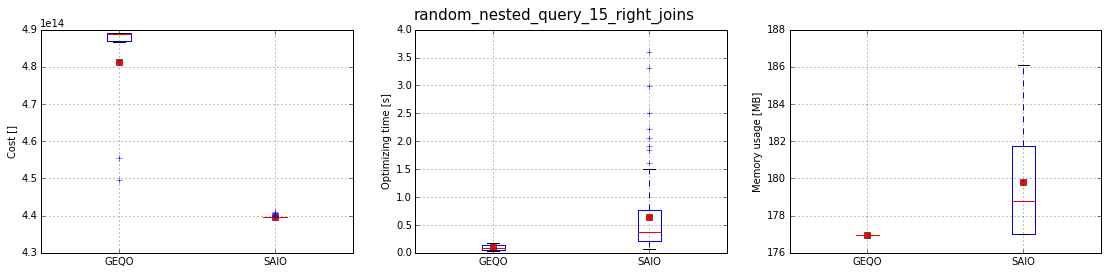

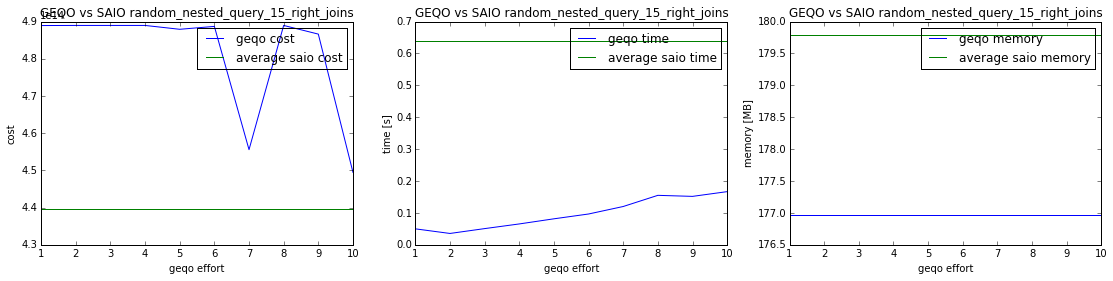

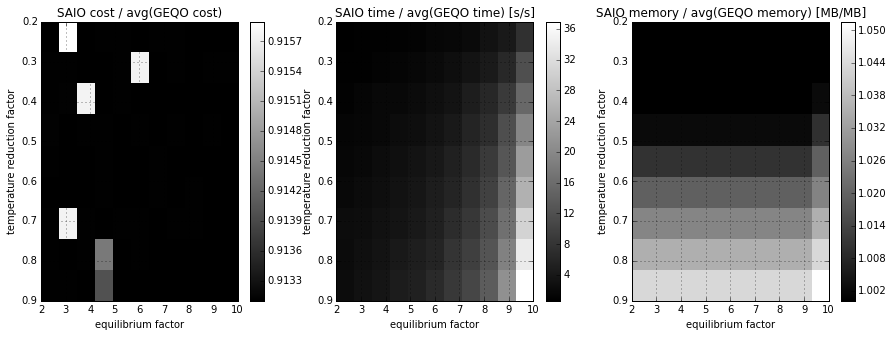

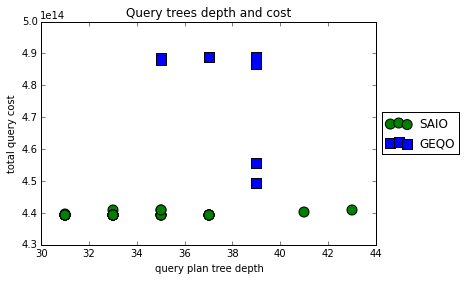

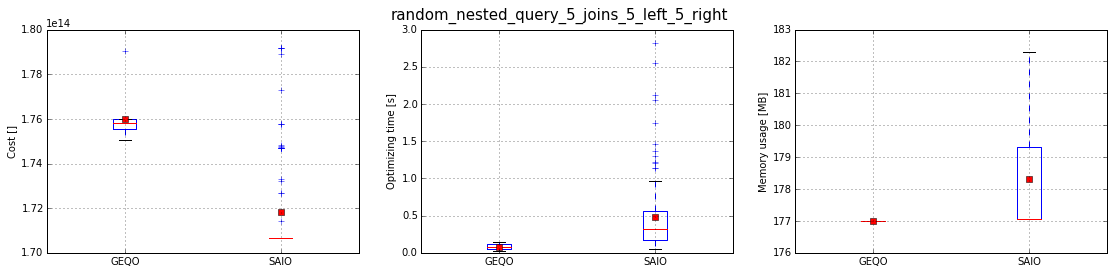

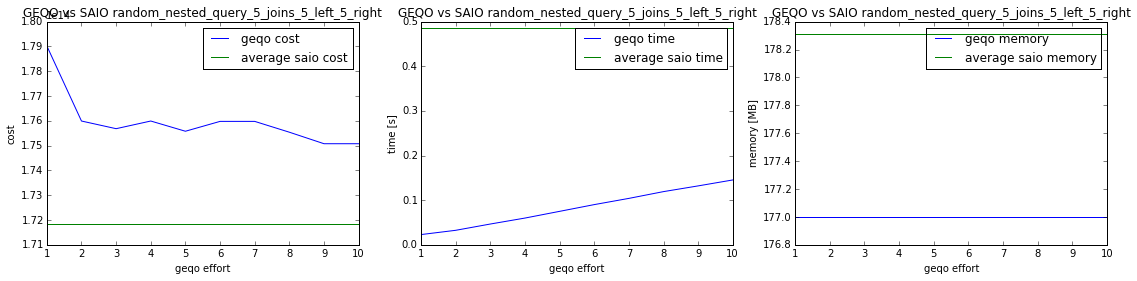

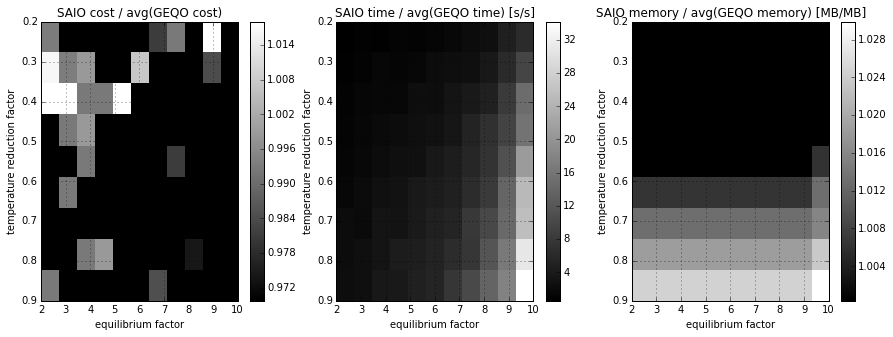

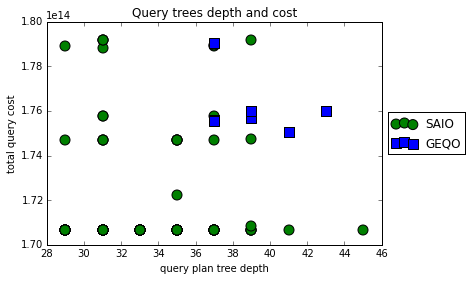

In [8]:
display_info_for_test_case('random_nested_query_15_joins')
display_info_for_test_case('random_nested_query_15_left_joins')
display_info_for_test_case('random_nested_query_15_right_joins')
display_info_for_test_case('random_nested_query_5_joins_5_left_5_right')

####20-25 JOINS

SAIO and GEQO are comparable for queries with 20-25 JOINS. GEQO wins at LEFT JOINS. SAIO wins at RIGHT JOINS.

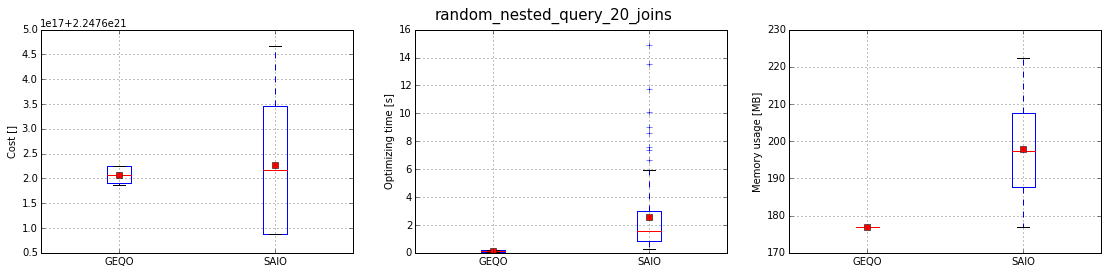

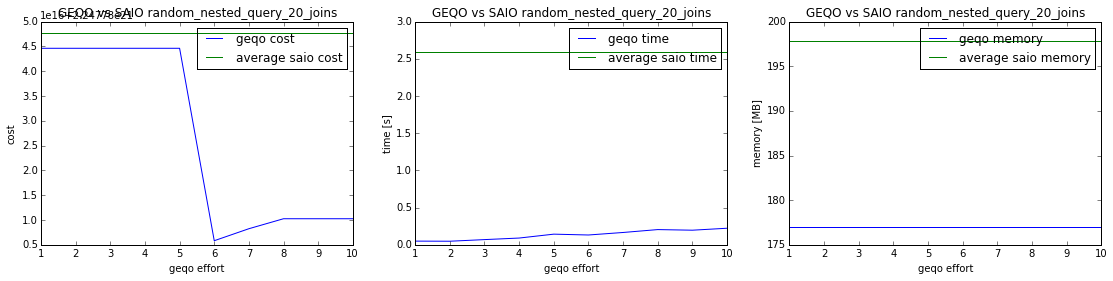

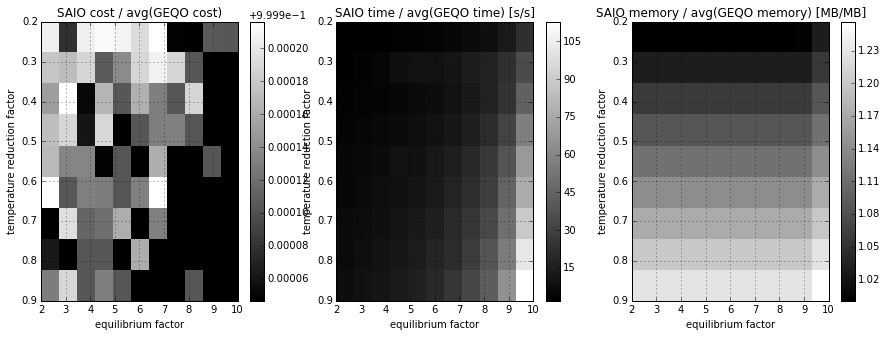

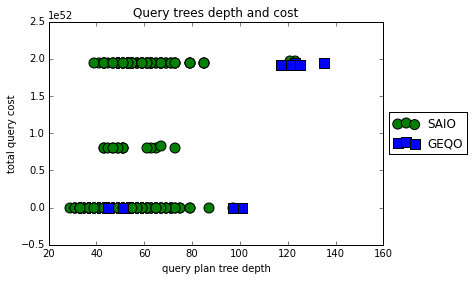

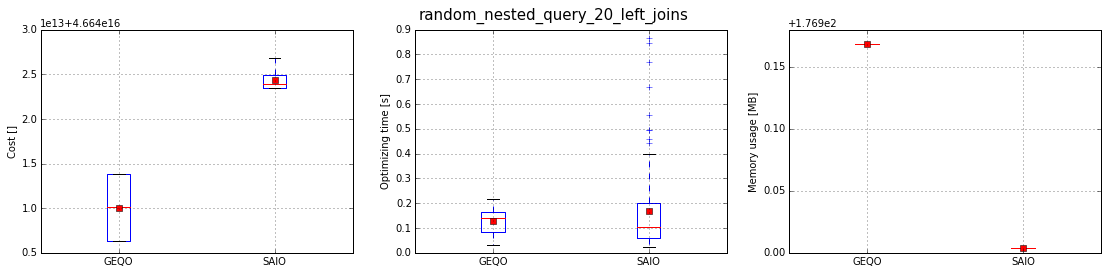

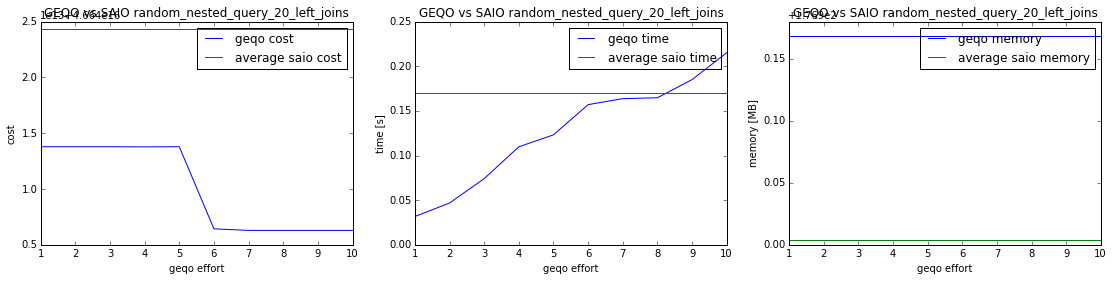

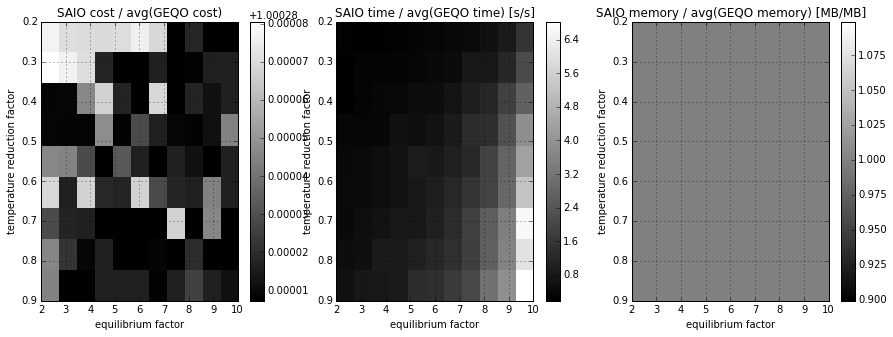

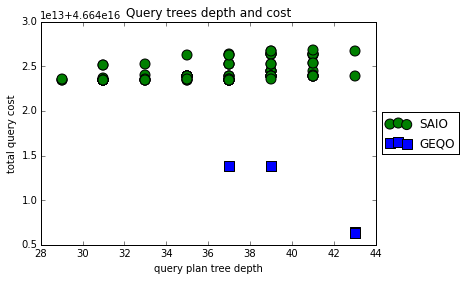

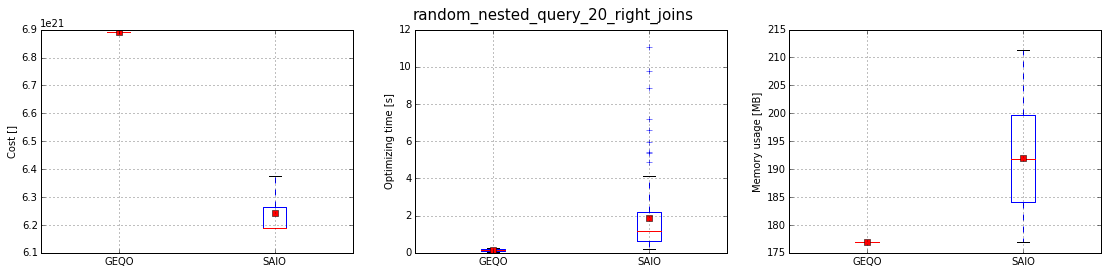

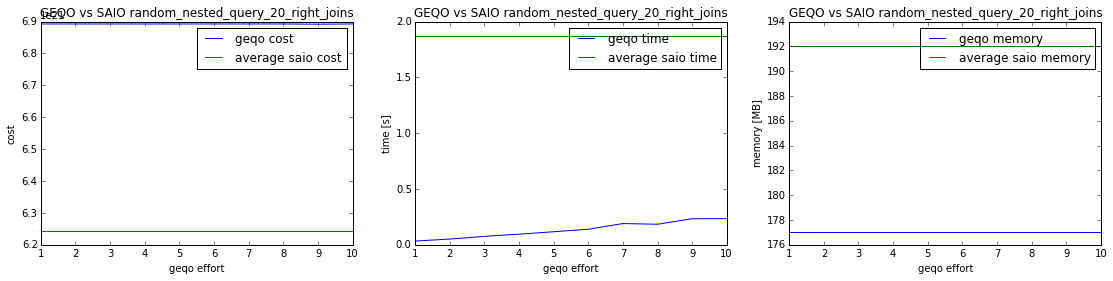

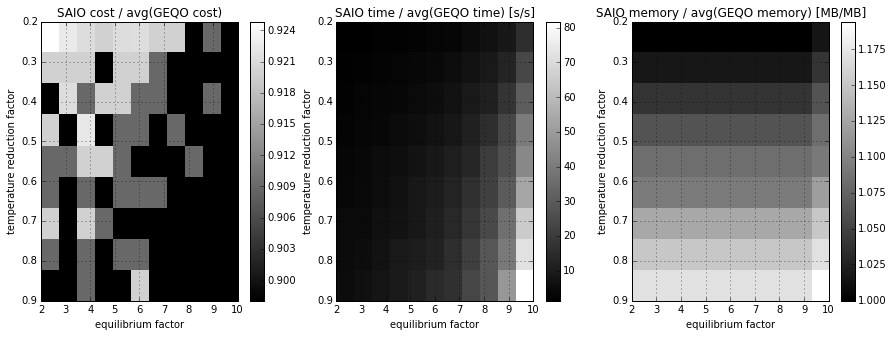

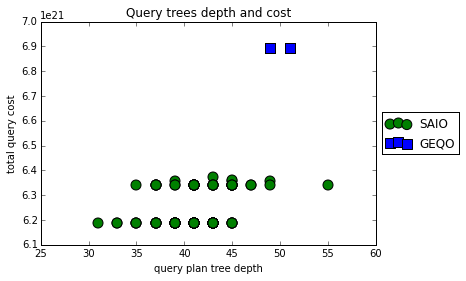

In [5]:
display_info_for_test_case('random_nested_query_20_joins')
display_info_for_test_case('random_nested_query_20_left_joins')
display_info_for_test_case('random_nested_query_20_right_joins')

####30-35 JOINS

Here SAIO finds better results for queries with 30-35 JOINS, RIGHT JOINS and mixed.

Solutions for queries with LEFT JOINS are comparable between GEQO and SAIO.

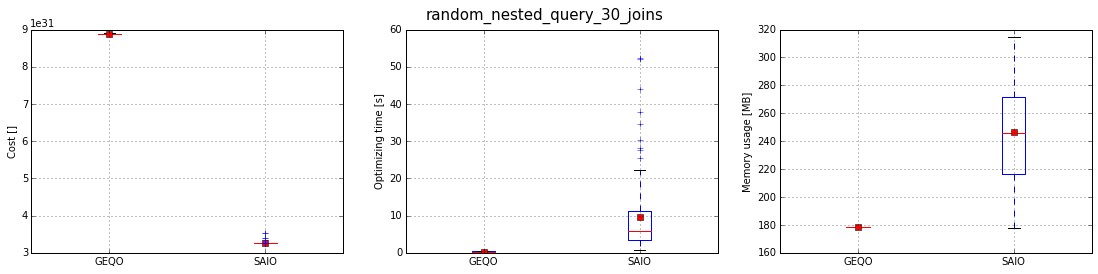

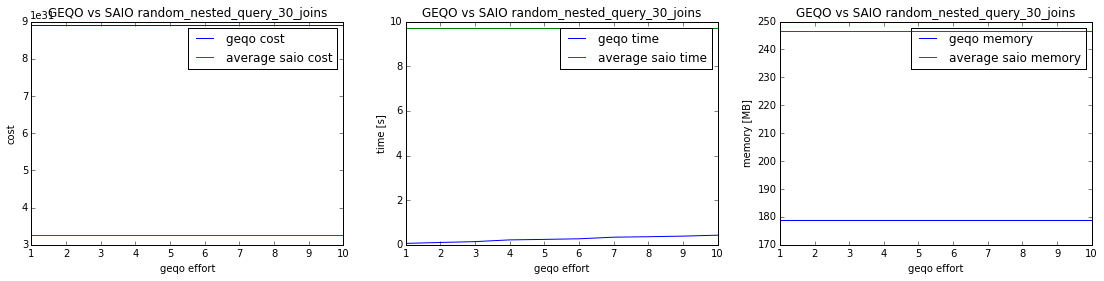

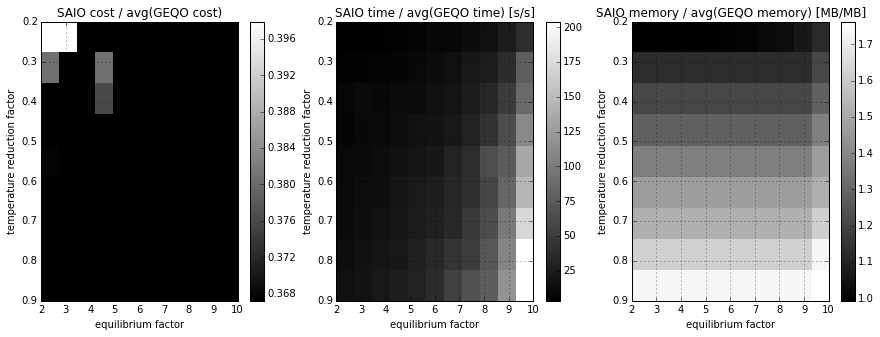

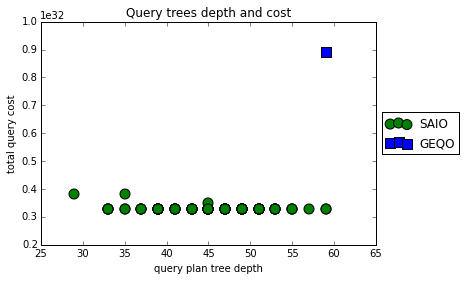

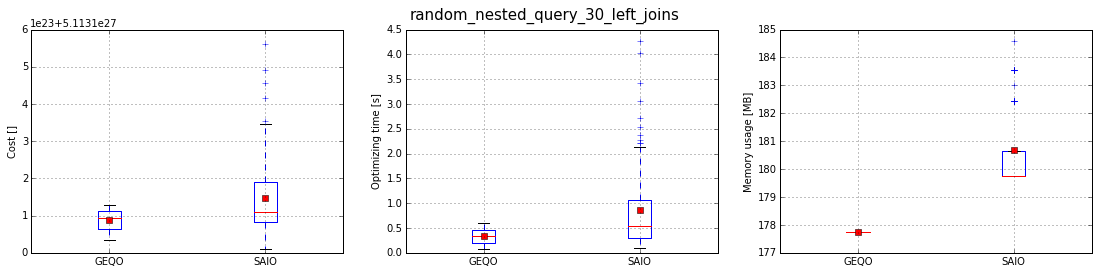

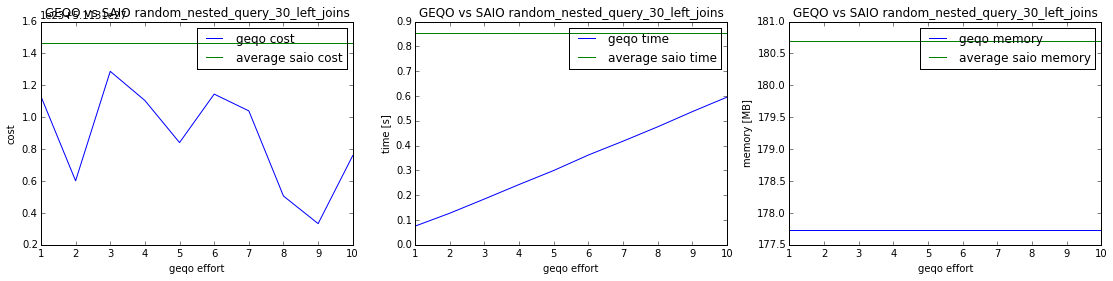

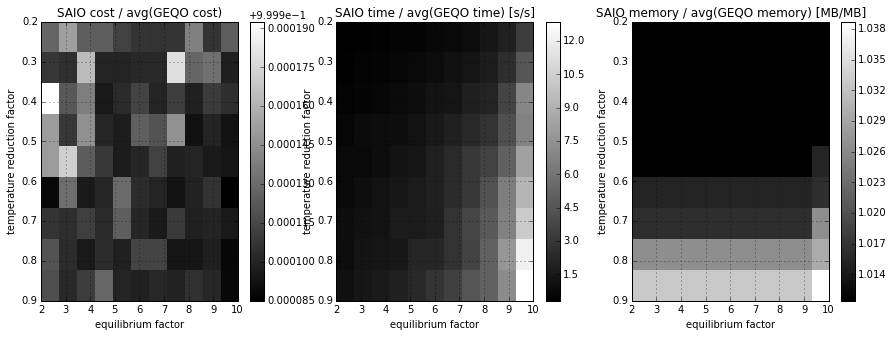

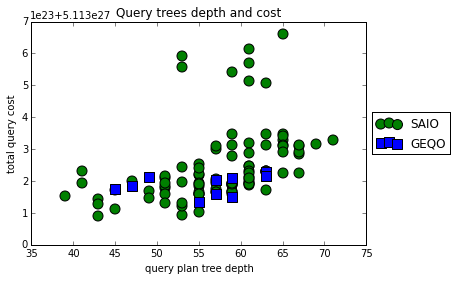

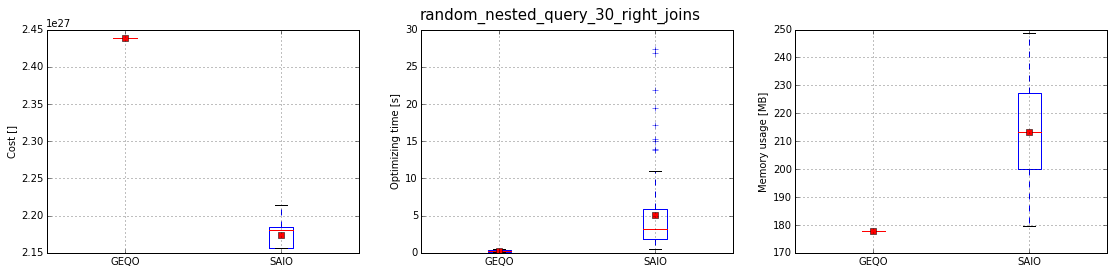

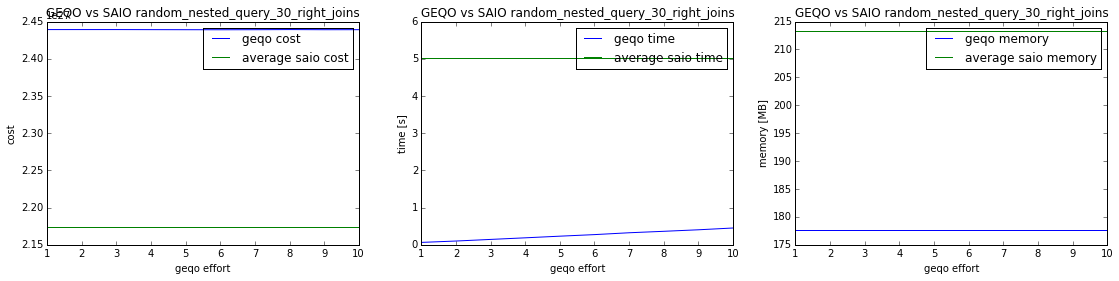

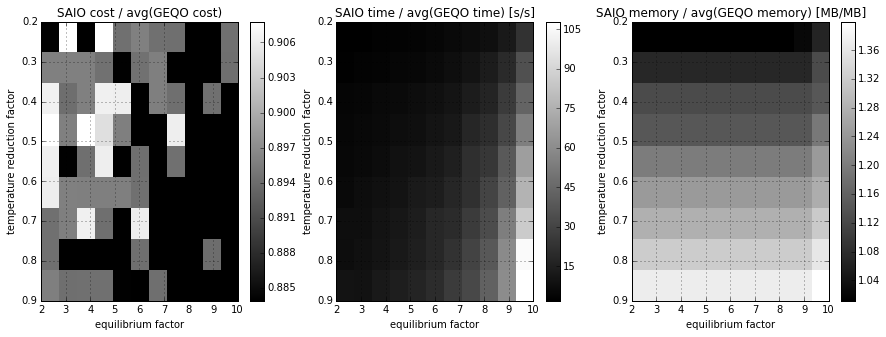

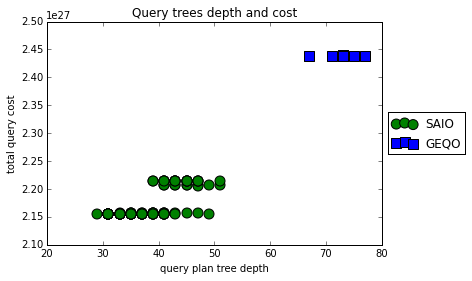

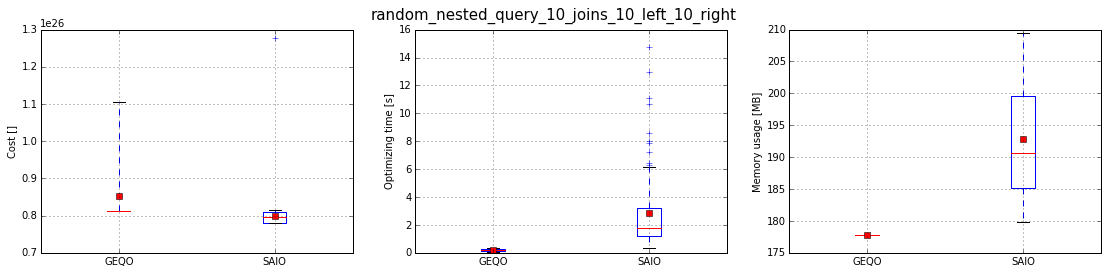

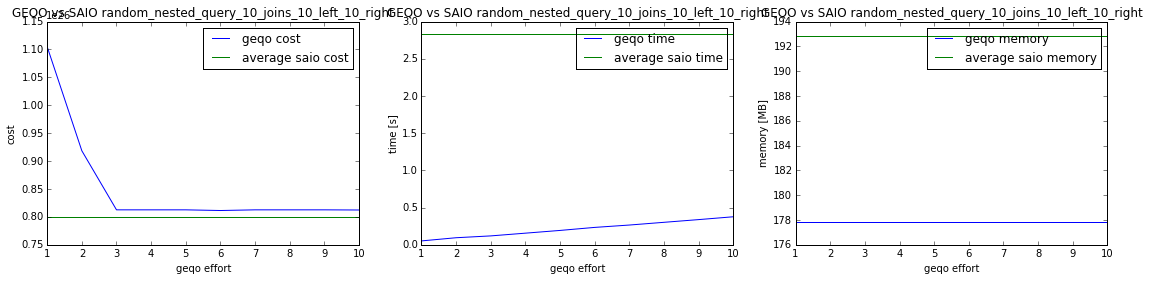

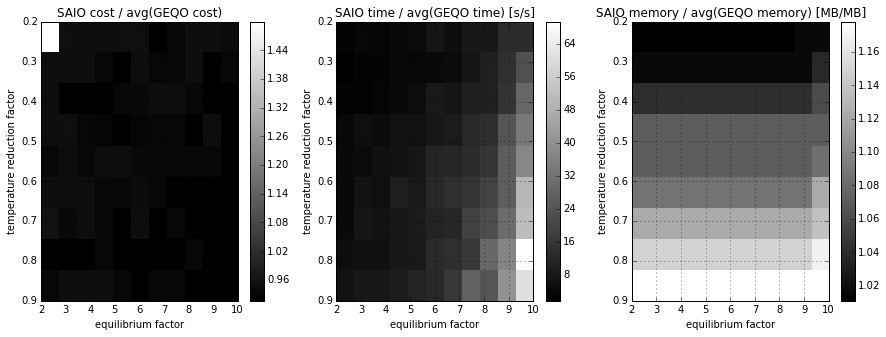

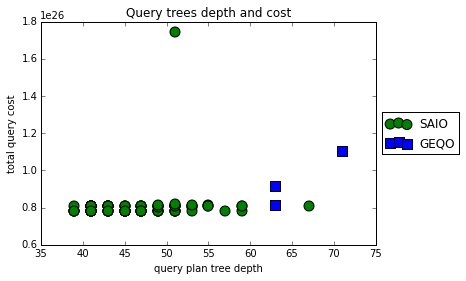

In [12]:
display_info_for_test_case('random_nested_query_30_joins')
display_info_for_test_case('random_nested_query_30_left_joins')
display_info_for_test_case('random_nested_query_30_right_joins')
display_info_for_test_case('random_nested_query_10_joins_10_left_10_right')

####50-60 joins

Looking at the costs, these queries would take almost forever to complete. But still it is visible that GEQO wins for queries that contain LEFT JOINS while SAIO wins at regular JOINS, RIGHT JOINS and mixed queries.

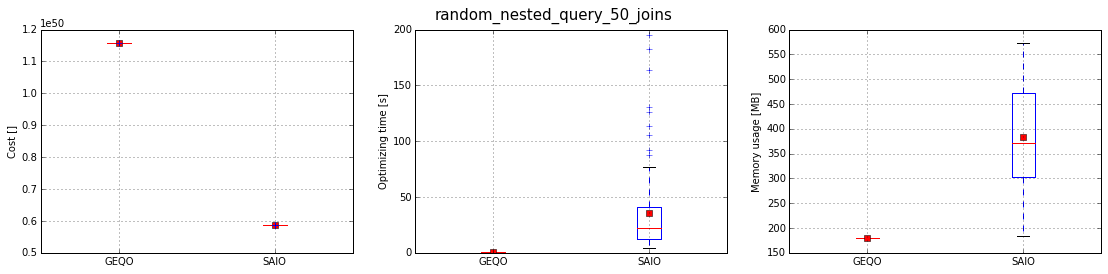

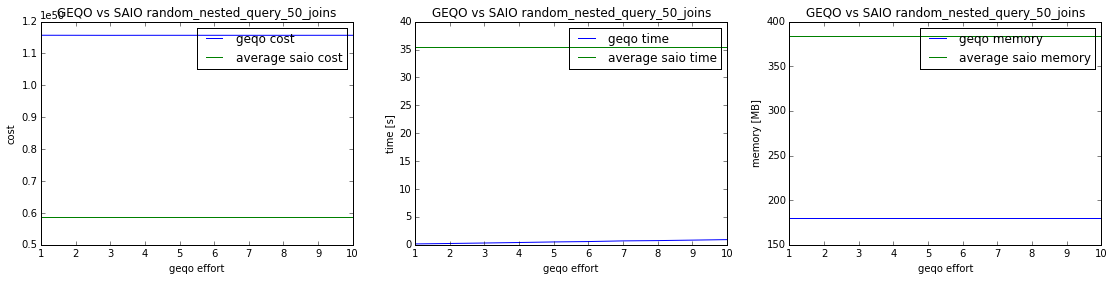

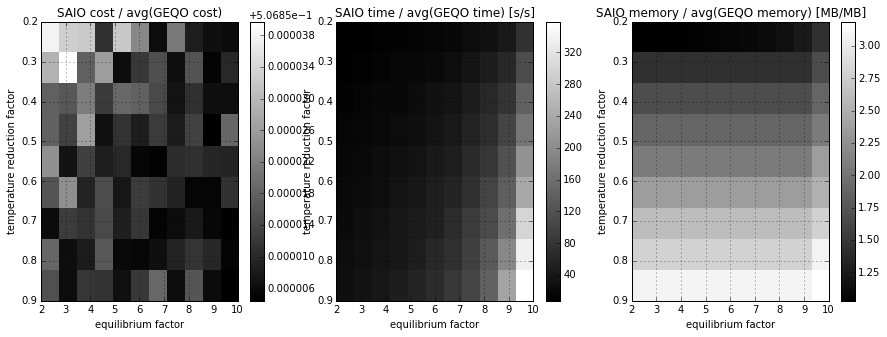

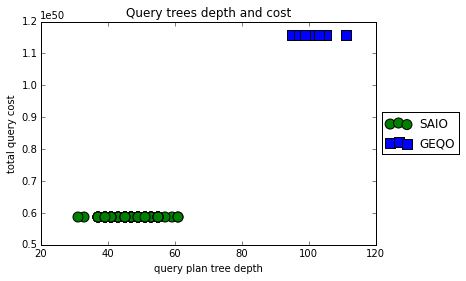

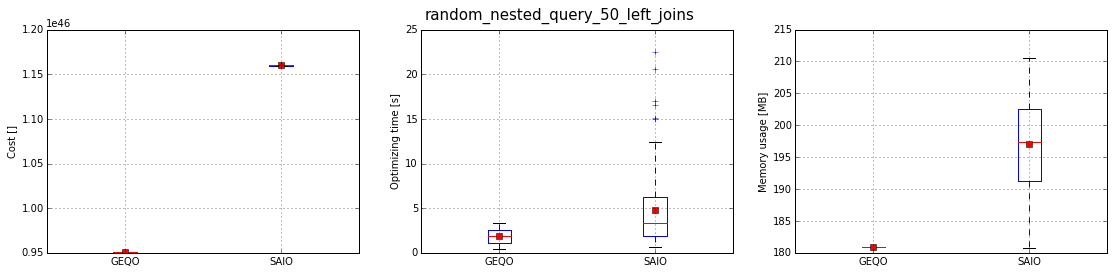

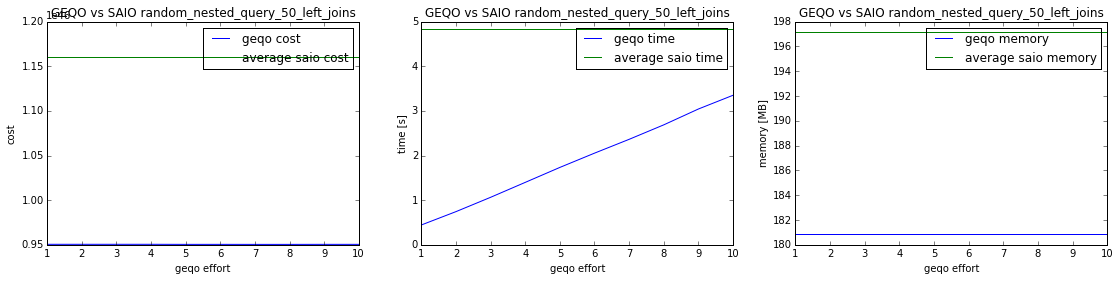

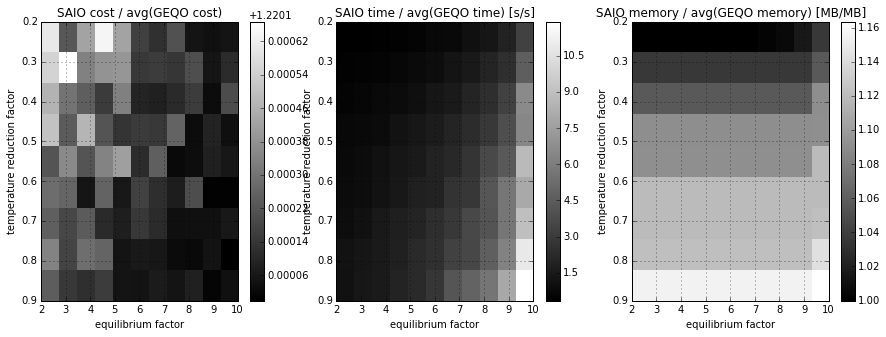

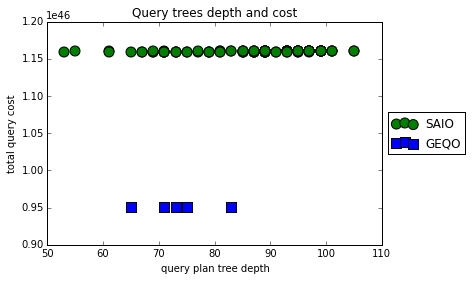

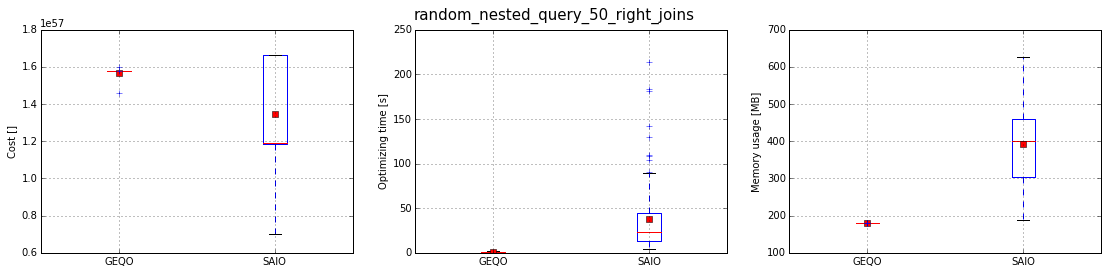

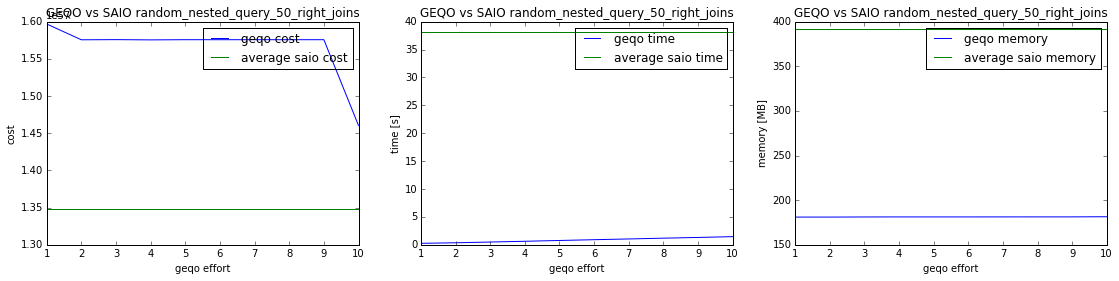

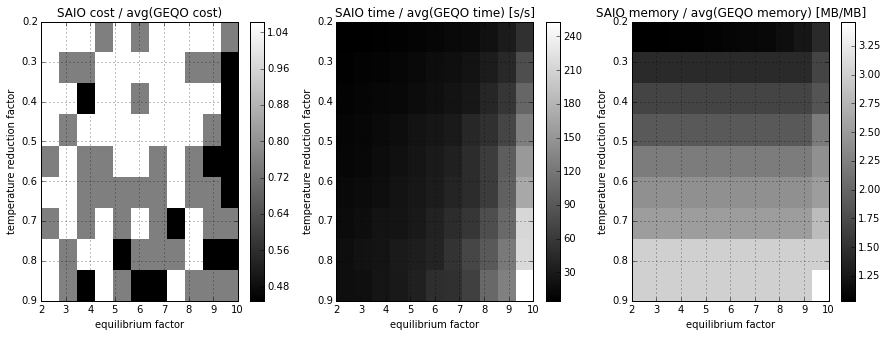

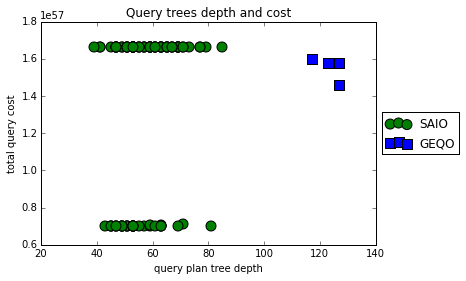

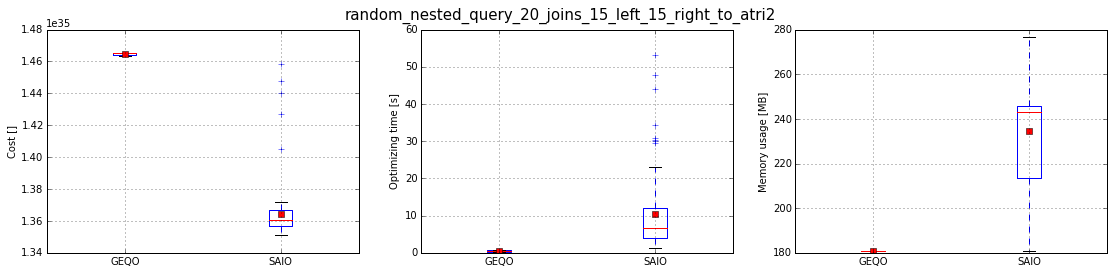

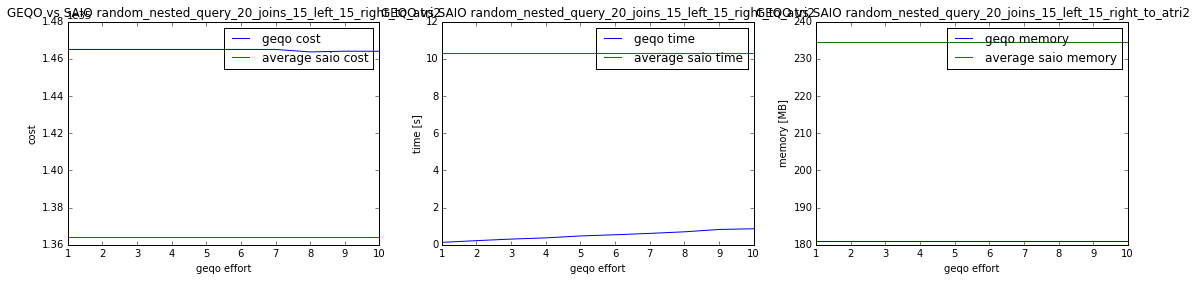

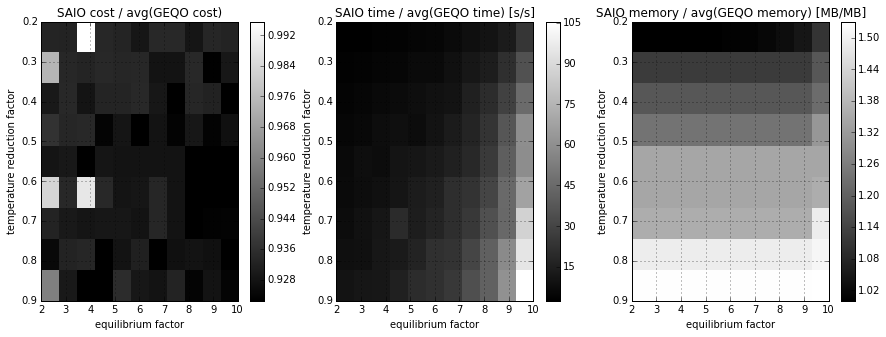

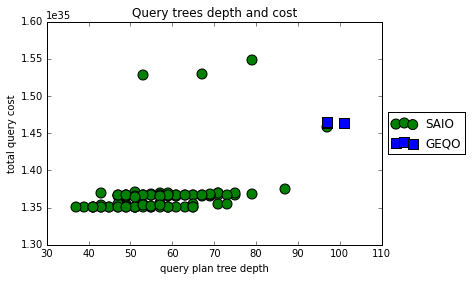

In [24]:
display_info_for_test_case('random_nested_query_50_joins')
display_info_for_test_case('random_nested_query_50_left_joins')
display_info_for_test_case('random_nested_query_50_right_joins')
display_info_for_test_case('random_nested_query_20_joins_15_left_15_right_to_atri2')

#### Two level nested query

For this query that has subqueries within subqueries and 4 joins, 3 left joins, 15 right joins in total, it is visible that SAIO easily beats GEQO finding a query with lower cost and using less memory. For the correct set of SAIO parameters, the computing time of SAIO may be also shorter than that of GEQO.

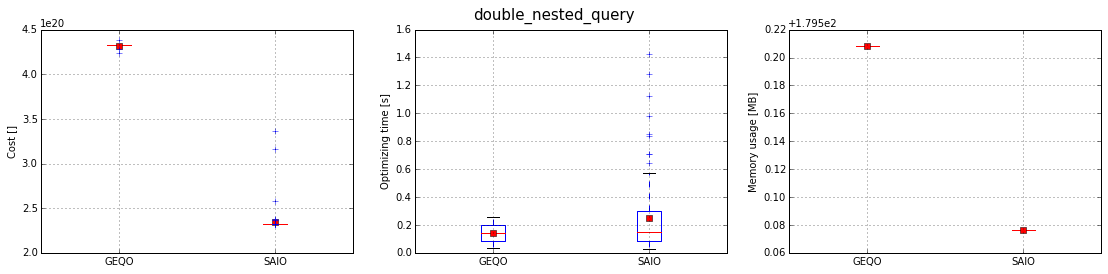

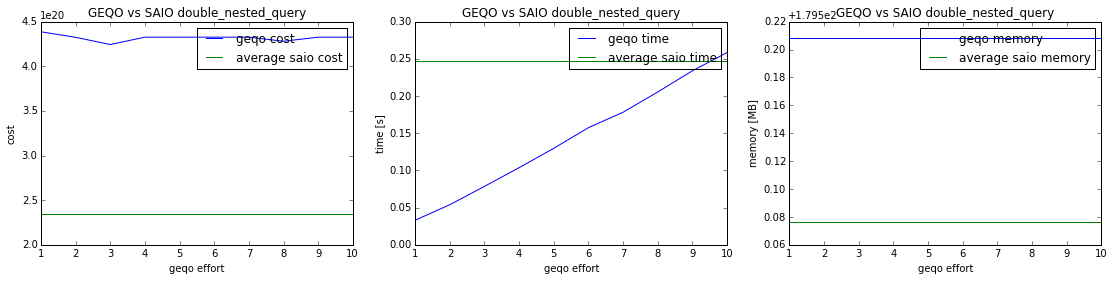

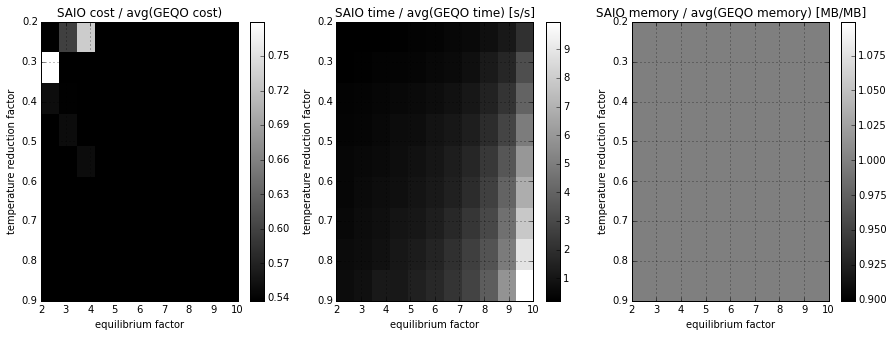

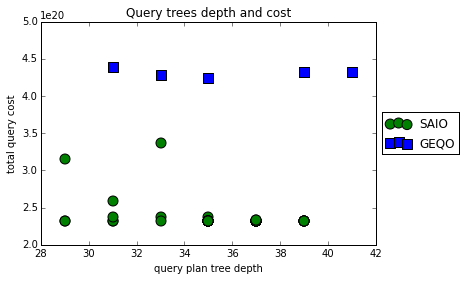

In [31]:
display_info_for_test_case('double_nested_query')

##Sample query trees

To illustrate solutions created by GEQO and SAIO, a few smaller query trees are included

###Query trees for cartesians

For queries with cartesian joins we can observe that both GEQO and SAIO produce trees of very similar topology.

**GEQO**
![](benchmarks/current_output/star_query_30_arms.geqo.out_plan_10_0_0_2.0.png)


**SAIO**
![](benchmarks/current_output/star_query_30_arms.saio.out_plan_10_3_0.9_2.png)




###Query trees for joins

For queries with joins the trees produced by GEQO and SAIO have similar topology.

**GEQO**
![](benchmarks/current_output/random_query_15_joins_no_constraints.geqo.out_plan_10_0_0_2.0.png)


**SAIO**
![](benchmarks/current_output/random_query_15_joins_no_constraints.saio.out_plan_10_3_0.9_2.png)




###Query trees for left joins

For queries with left joins the trees produced by GEQO and SAIO have similar topology.

**GEQO**
![](benchmarks/current_output/random_query_15_left_joins_no_constraints.geqo.out_plan_10_0_0_2.0.png)


**SAIO**
![](benchmarks/current_output/random_query_15_left_joins_no_constraints.saio.out_plan_10_3_0.9_2.png)




###Query trees for right joins

For queries with right joins we can observe that the trees produced by GEQO and SAIO look much different. The GEQO tree is left-deep and SAIO tree is bushy. 

**GEQO**
![](benchmarks/current_output/random_query_15_right_joins_no_constraints.geqo.out_plan_10_0_0_2.0.png)


**SAIO**
![](benchmarks/current_output/random_query_15_right_joins_no_constraints.saio.out_plan_10_3_0.9_2.png)

###Query trees for nested queries

Here we can observe that trees produced by GEQO and SAIO have different topologies again. This is because we have some right joins here.

**GEQO**
![](benchmarks/current_output/random_nested_query_15_joins.geqo.out_plan_10_0_0_2.0
.png)

**SAIO**
![](benchmarks/current_output/random_nested_query_15_joins.saio.out_plan_10_3_0.9_2
.png)

### Query trees for double nested query

Here both trees look pretty bushy.

**GEQO**
![](benchmarks/current_output/double_nested_query.geqo.out_plan_10_0_0_2.0.png)

**SAIO**
![](benchmarks/current_output/double_nested_query.saio.out_plan_10_3_0.9_2.png)